# Wizualizacje i notatki odnośnie eksperymentów 
Notatnik ten posłuży do zgromadzenia wstępnych przemyśleń odnośnie przeprowadzonych eksperymentów, a także przedstawi wizualizacje wyników.

## Plan eksperymentu
Eksperyment w pierwszych trzech etapach będzie służył do ustalenia najwydajniejszego enkodera oraz najlepiej działającej funkcji straty. Etap czwarty dotyczy z kolei już właściwego eksperymentu, który stanowi główny cel pracy. 

Porównania dla etapów 1 - 3 będą realizowane poprzez przeprowadzenie treningu oraz pomiarów na 2 stałych parametrach oraz 1 zmiennym. Wstępnie na drodze wcześniejszych testów ustalono z kolei parametry, od których rozpoczęte zostanie wstępne badanie:
- architektura: `DeepLabV3` - spodziewany faworyt,
- enkoder: `resnext50_32x4d` - dobre wyniki, wymaga stosunkowo mało VRAMu,
- strata: $Dice Loss \times 0.8 + Focal Loss \times 0.2$ - takie połączenie zapewnia dobre uogólnianie oraz zapewnienie uwagi małym klasom.

Poniżej znajduje się bardziej szczegółowy opis:

- **Etap 1 - wstępne porównanie architektur**

    Porównanie wielu dostępnych w SMP architektur sieci neuronowych w celu wyłonienia czterech dających najciekawsze wyniki. Pod uwagę przede wszystkim będzie brana przede wszystkim specyfika modelu, ale również jego końcowa wydajność i jakość klasyfikacji.

- **Etap 2 - porównanie enkoderów**

    Porównanie wybranych enkoderów dostępnych w projekcie SMP. Wszystkie enkodery musiały obsługiwać wagi `imagenet` oraz mieścić się na 12GB VRAM (razem z najlepszą architekturą wyłonioną w etapie 1). Wybrano kilka wariantów `resnet50`, reprezentujących klasyczne przykłady dla problemu segmentacji, kilka nowocześniejszych podejść jak `efficient-b4`, `mit-b1` oraz ostatecznie jeden enkoder bardzo lekki (`mobileone_s4`, zapewniający w teorii szybkie przetwarzanie) oraz jeden bardzo ciężki (`resnext101_32x8d`). Ostateczni zostanie wyłoniony jeden enkoder, który będzie wyróżniał się pod względem jakości oraz wydajności.

- **Etap 3 - porównanie funkcji straty**

    Porównanie wybranych podejść do obliczania funkcji straty



### Przetwarzanie danych z metryk

In [1]:
import os, glob
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from warnings import showwarning

def get_metrics_files(
        logs_root, 
        backbones: list = [],
        encoders: list = []
    ):
    backbones = backbones or glob.glob(root_dir=logs_root, pathname='*')
    print(backbones)

    metrics_files = {}
    for backbone in backbones:
        log_root = os.path.join(logs_root, backbone)
        versions = glob.glob(os.path.join(log_root, 'version_*'))
        for version_pth in versions:
            version = version_pth.split('_')[1]
            metadata = get_metadata(version_pth)
            if metadata and encoders:
                encoder = get_metadata_field(metadata, 'encoder')
                if encoder in encoders:
                    metrics_files.update({version_pth: [backbone, version]})
            else:
                metrics_files.update({version_pth: [backbone, version]})
    return metrics_files

def get_metadata(log_root):
    metadata_file = os.path.join(log_root, 'metadata.yaml')
    if not os.path.exists(metadata_file):
        return None
    with open(metadata_file, 'r') as f:
        metadata = yaml.safe_load(f)
    return metadata

def get_metadata_field(metadata: dict, key: str):
    for d in metadata.get('model', []):
        if key in d:
            return d[key]
    return None

def draw_backbone_comparision_plot(
    metrics_files,
    y_metric,
    x_metric = 'epoch',
    title = None,
    subject = 'model'
):
    plt.figure()
    for file in metrics_files.items():
        metric_file = os.path.join(file[0], f'metrics_fixed.csv')
        if os.path.exists(metric_file):
            metrics = pd.read_csv(metric_file)
            metadata = get_metadata(file[0])
            if metadata:
                plt.plot(metrics[x_metric], metrics[y_metric], label=get_metadata_field(metadata, subject))
            else:
                # legacy
                plt.plot(metrics[x_metric], metrics[y_metric], label=file[1][0])

    plt.title(title)
    plt.xlabel(x_metric)
    plt.ylabel(y_metric)
    plt.legend()
    plt.tight_layout()
    plt.show()

def visualize_accumulated(
    metrics_files,
    y_metric,
    title = None,
    agg='mean',
    subject = 'model'
):
    labels = []
    values = []

    for folder, info in metrics_files.items():
        
        metric_file = os.path.join(folder, 'metrics_fixed.csv')
        if not os.path.exists(metric_file):
            continue

        df = pd.read_csv(metric_file)
        if agg == 'sum':
            val = df[y_metric].sum()
        elif agg == 'mean':
            val = df[y_metric].tail(10).mean()
        else:
            # jeśli np. agg to callable albo nazwa agregacji
            val = df[y_metric].agg(agg)

        metadata = get_metadata(folder)
        subject_value = get_metadata_field(metadata, subject) if metadata else info[0]
        labels.append(subject_value)
        values.append(val)

    # pozycje na osi x
    x = np.arange(len(labels))

    plt.figure(figsize=(8, 5))
    bars = plt.bar(x, values)

    for bar in bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,  # środek słupka
            yval,                                # wysokość słupka
            f'{yval:.3f}',                       # format liczby, tu z 3 miejscami po przecinku
            ha='center', va='bottom'             # wyśrodkowanie, tekst nad słupkiem
        )

    plt.xticks(x, labels, rotation=45, ha='right')
    plt.ylabel(y_metric)
    if title:
        plt.title(title)
    plt.tight_layout()
    plt.show()

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

logs_root = ".\\checkpoints\\stage1"

comparision_metrics = [
    ['Zmiana funkcji strty dla różnych backbonów', 'train_loss'],
    ['Zmiana lr dla różnych backbonów', 'lr'],
    ['Zmiana mIoU dla różnych backbonów', 'val_miou_dataset'],
    ['Zmiana accuracy dla różnych backbonów', 'val_acc_macro'],
    ['Zmiana precision dla różnych backbonów', 'val_prec_macro'],
    ['Zmiana recall dla różnych backbonów', 'val_rec_macro'],
    ['Zmiana F1 dla różnych backbonów', 'val_f1_macro'],
    ['Zmiana IoU obiektu pole dla różnych backbonów', 'iou_pole'],
    ['Zmiana F1 obiektu pole dla różnych backbonów', 'f1_pole'],
    ['Zmiana IoU obiektu car dla różnych backbonów', 'iou_car'],
    ['Zmiana F1 obiektu car dla różnych backbonów', 'f1_car'],
    ['Zmiana IoU obiektu truck dla różnych backbonów', 'iou_truck'],
    ['Zmiana F1 obiektu truck dla różnych backbonów', 'f1_truck']
]

## Wstępne porównanie architektur
Niniejsza sekcja dotyczy wstępnego porównania architektur, w celu wyłonienia **czterech prezentujących najciekawsze wyniki**. Porównane zostaną wybrane miary oraz klasy, które sprawiały trudność przy wstępnych eksperymentach.

### Eksperyment wstępny

['DeepLabV3Plus', 'DeepLabV3', 'Linknet', 'Segformer', 'Unet', 'UnetPlusPlus', 'FPN', 'PAN', 'UPerNet', 'DPT', 'MAnet', 'PSPNet']


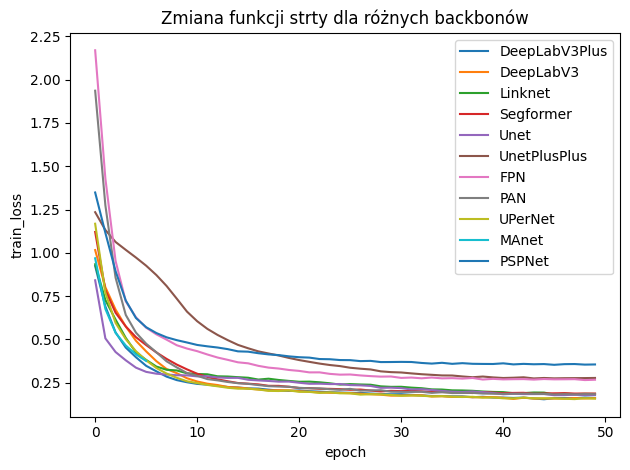

['DeepLabV3Plus', 'DeepLabV3', 'Linknet', 'Segformer', 'Unet', 'UnetPlusPlus', 'FPN', 'PAN', 'UPerNet', 'DPT', 'MAnet', 'PSPNet']


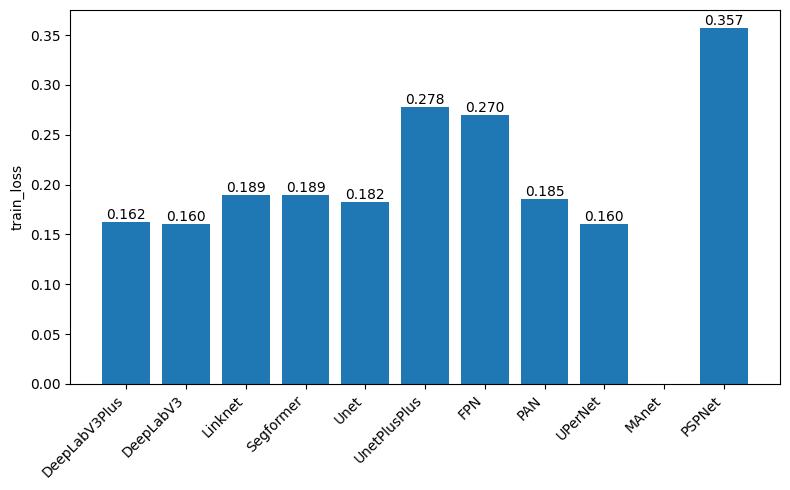

['DeepLabV3Plus', 'DeepLabV3', 'Linknet', 'Segformer', 'Unet', 'UnetPlusPlus', 'FPN', 'PAN', 'UPerNet', 'DPT', 'MAnet', 'PSPNet']


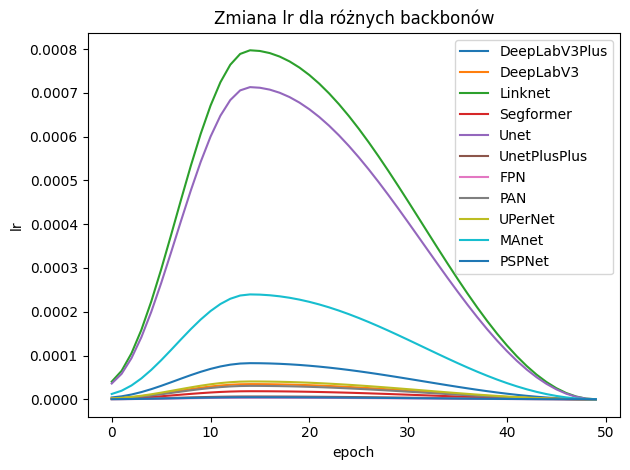

['DeepLabV3Plus', 'DeepLabV3', 'Linknet', 'Segformer', 'Unet', 'UnetPlusPlus', 'FPN', 'PAN', 'UPerNet', 'DPT', 'MAnet', 'PSPNet']


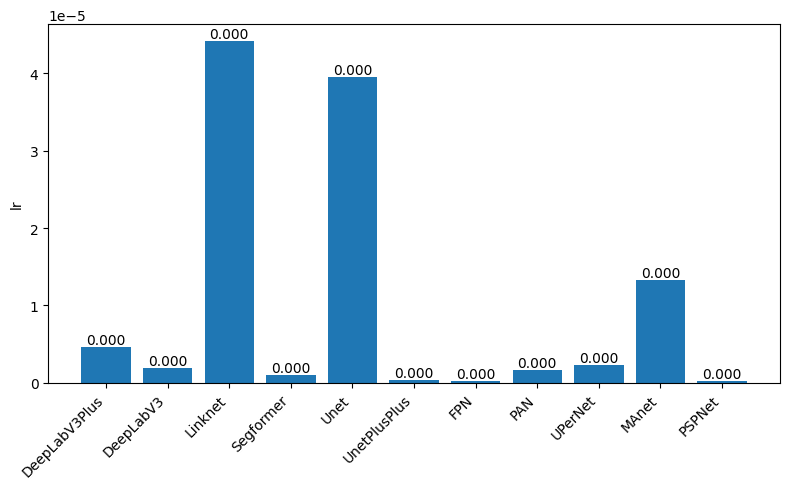

['DeepLabV3Plus', 'DeepLabV3', 'Linknet', 'Segformer', 'Unet', 'UnetPlusPlus', 'FPN', 'PAN', 'UPerNet', 'DPT', 'MAnet', 'PSPNet']


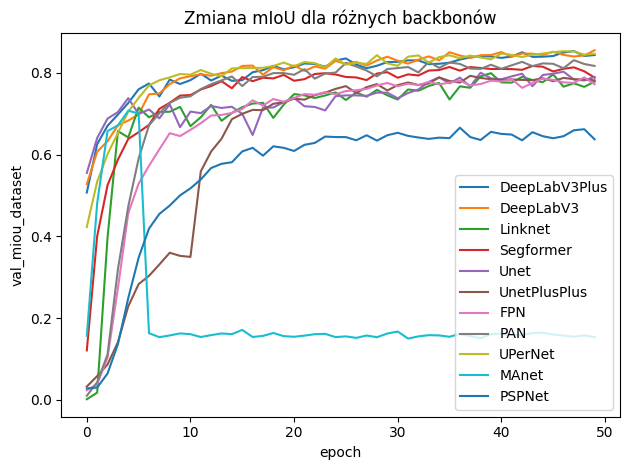

['DeepLabV3Plus', 'DeepLabV3', 'Linknet', 'Segformer', 'Unet', 'UnetPlusPlus', 'FPN', 'PAN', 'UPerNet', 'DPT', 'MAnet', 'PSPNet']


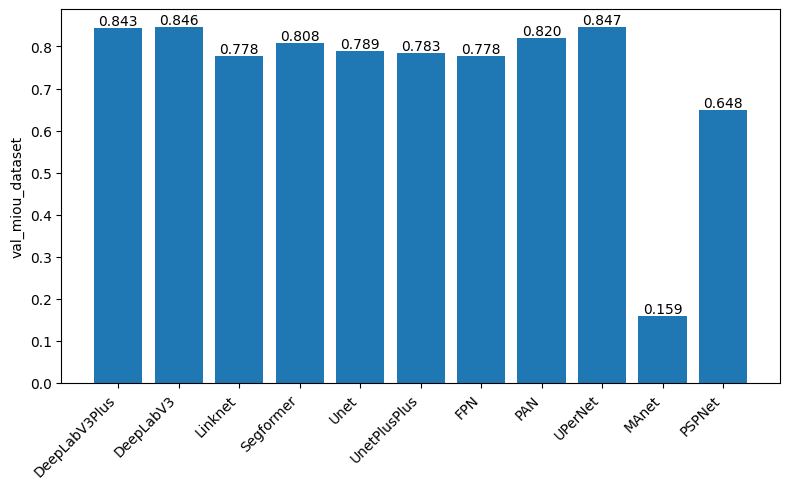

['DeepLabV3Plus', 'DeepLabV3', 'Linknet', 'Segformer', 'Unet', 'UnetPlusPlus', 'FPN', 'PAN', 'UPerNet', 'DPT', 'MAnet', 'PSPNet']


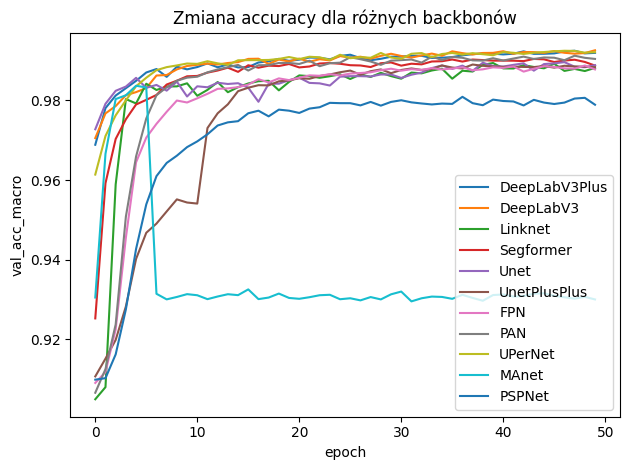

['DeepLabV3Plus', 'DeepLabV3', 'Linknet', 'Segformer', 'Unet', 'UnetPlusPlus', 'FPN', 'PAN', 'UPerNet', 'DPT', 'MAnet', 'PSPNet']


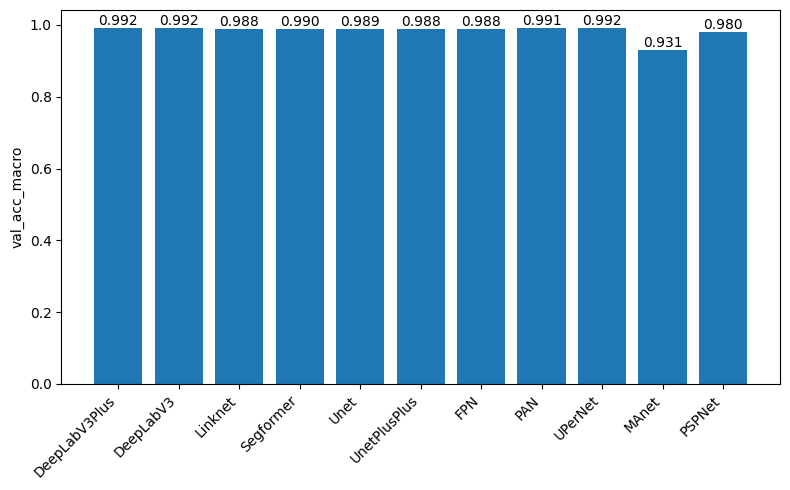

['DeepLabV3Plus', 'DeepLabV3', 'Linknet', 'Segformer', 'Unet', 'UnetPlusPlus', 'FPN', 'PAN', 'UPerNet', 'DPT', 'MAnet', 'PSPNet']


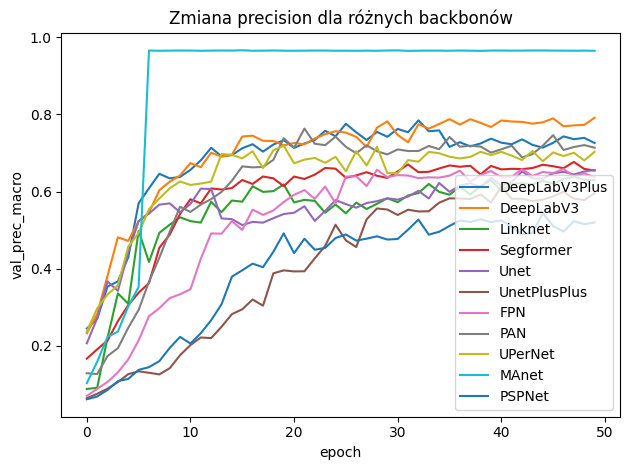

['DeepLabV3Plus', 'DeepLabV3', 'Linknet', 'Segformer', 'Unet', 'UnetPlusPlus', 'FPN', 'PAN', 'UPerNet', 'DPT', 'MAnet', 'PSPNet']


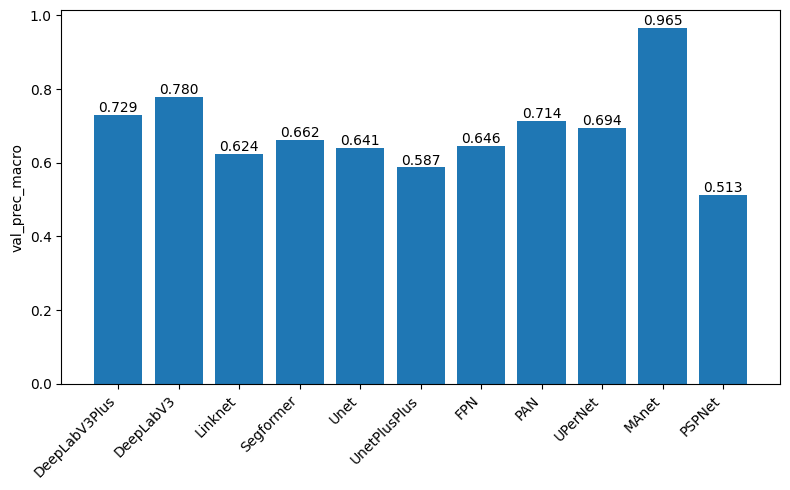

['DeepLabV3Plus', 'DeepLabV3', 'Linknet', 'Segformer', 'Unet', 'UnetPlusPlus', 'FPN', 'PAN', 'UPerNet', 'DPT', 'MAnet', 'PSPNet']


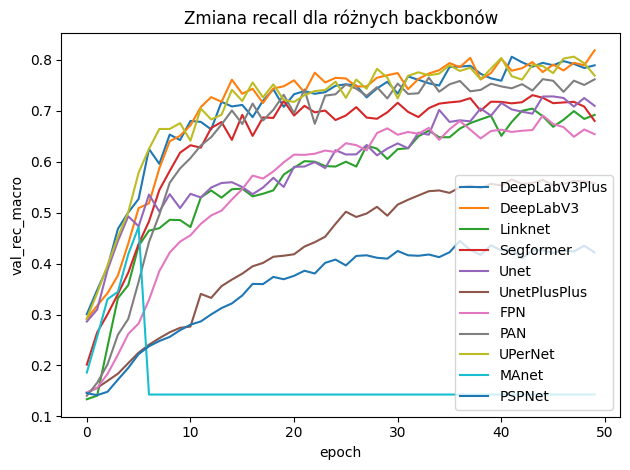

['DeepLabV3Plus', 'DeepLabV3', 'Linknet', 'Segformer', 'Unet', 'UnetPlusPlus', 'FPN', 'PAN', 'UPerNet', 'DPT', 'MAnet', 'PSPNet']


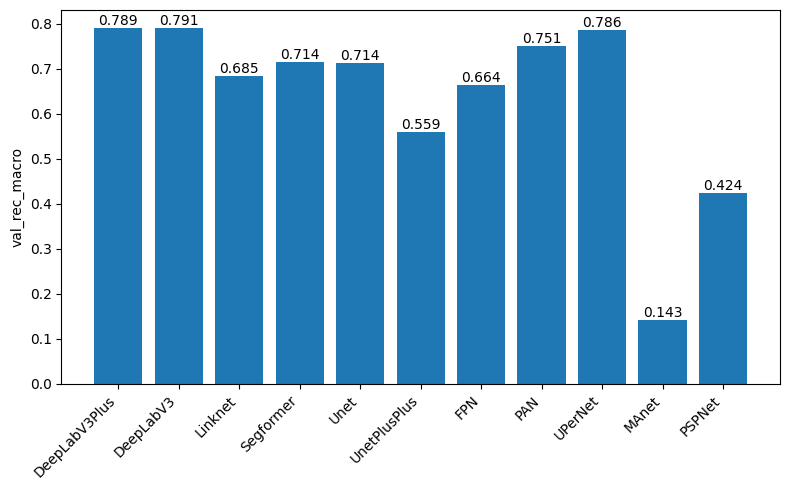

['DeepLabV3Plus', 'DeepLabV3', 'Linknet', 'Segformer', 'Unet', 'UnetPlusPlus', 'FPN', 'PAN', 'UPerNet', 'DPT', 'MAnet', 'PSPNet']


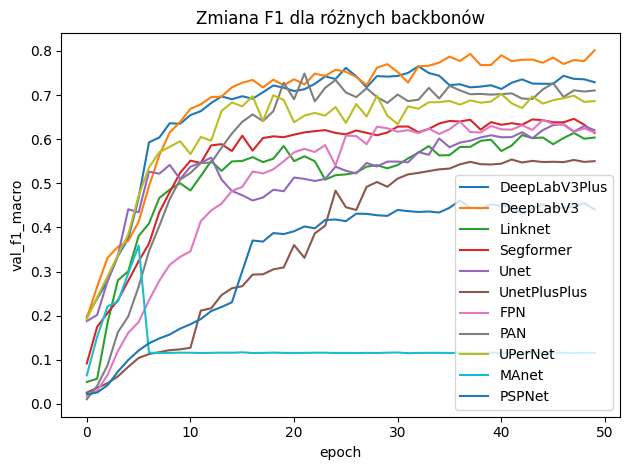

['DeepLabV3Plus', 'DeepLabV3', 'Linknet', 'Segformer', 'Unet', 'UnetPlusPlus', 'FPN', 'PAN', 'UPerNet', 'DPT', 'MAnet', 'PSPNet']


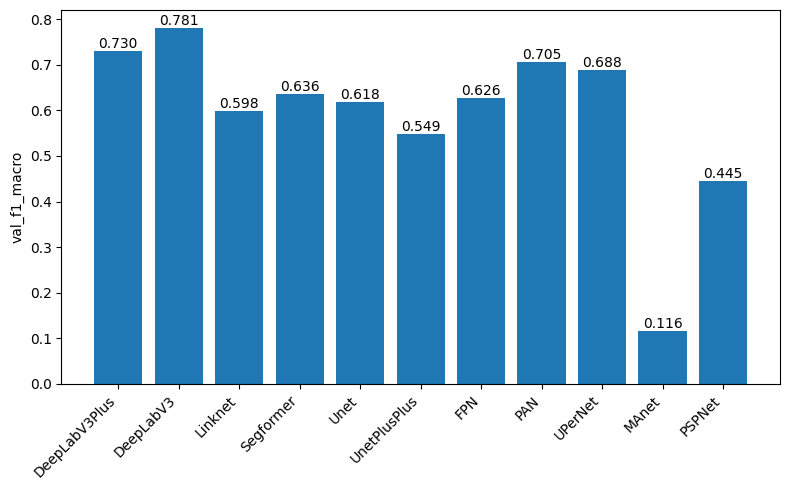

['DeepLabV3Plus', 'DeepLabV3', 'Linknet', 'Segformer', 'Unet', 'UnetPlusPlus', 'FPN', 'PAN', 'UPerNet', 'DPT', 'MAnet', 'PSPNet']


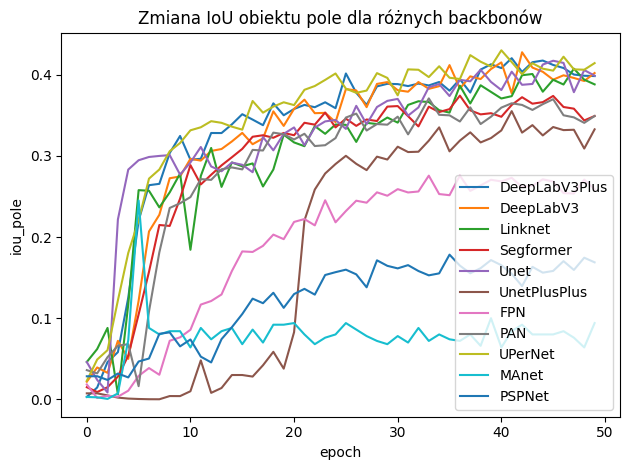

['DeepLabV3Plus', 'DeepLabV3', 'Linknet', 'Segformer', 'Unet', 'UnetPlusPlus', 'FPN', 'PAN', 'UPerNet', 'DPT', 'MAnet', 'PSPNet']


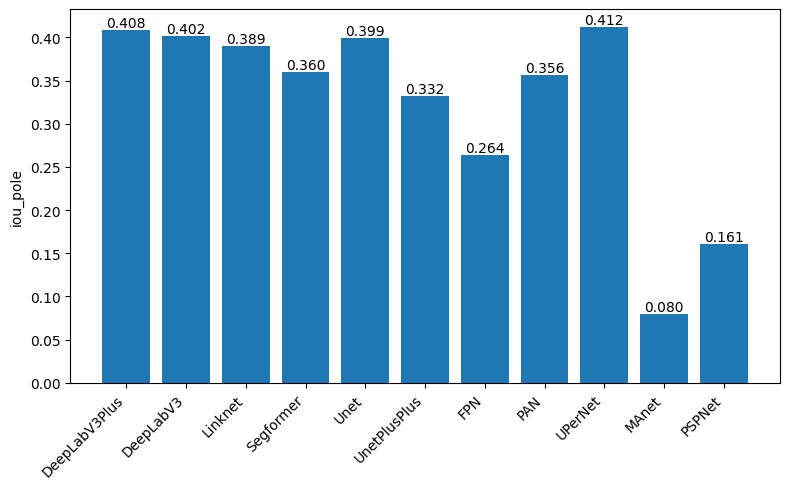

['DeepLabV3Plus', 'DeepLabV3', 'Linknet', 'Segformer', 'Unet', 'UnetPlusPlus', 'FPN', 'PAN', 'UPerNet', 'DPT', 'MAnet', 'PSPNet']


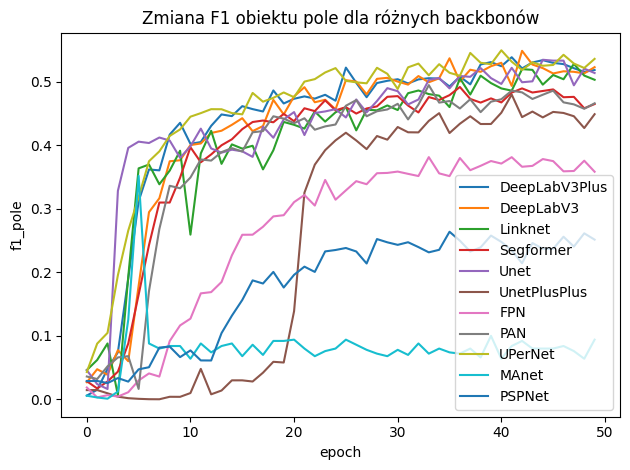

['DeepLabV3Plus', 'DeepLabV3', 'Linknet', 'Segformer', 'Unet', 'UnetPlusPlus', 'FPN', 'PAN', 'UPerNet', 'DPT', 'MAnet', 'PSPNet']


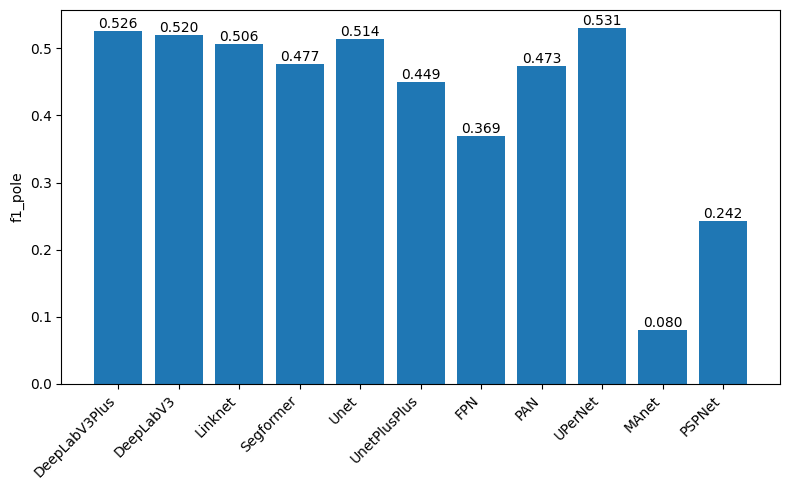

['DeepLabV3Plus', 'DeepLabV3', 'Linknet', 'Segformer', 'Unet', 'UnetPlusPlus', 'FPN', 'PAN', 'UPerNet', 'DPT', 'MAnet', 'PSPNet']


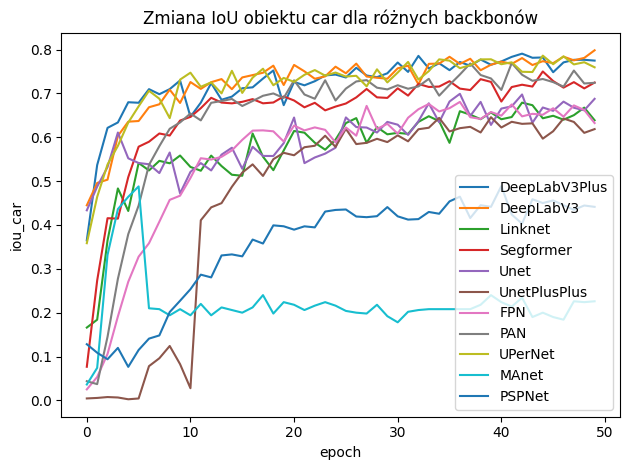

['DeepLabV3Plus', 'DeepLabV3', 'Linknet', 'Segformer', 'Unet', 'UnetPlusPlus', 'FPN', 'PAN', 'UPerNet', 'DPT', 'MAnet', 'PSPNet']


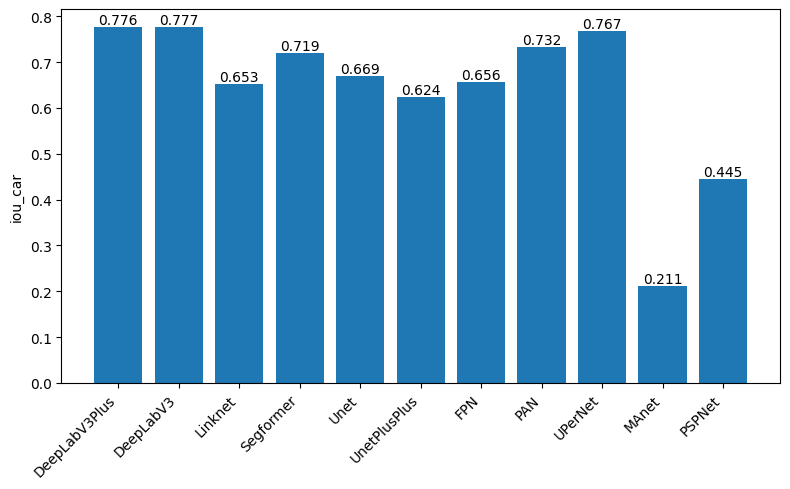

['DeepLabV3Plus', 'DeepLabV3', 'Linknet', 'Segformer', 'Unet', 'UnetPlusPlus', 'FPN', 'PAN', 'UPerNet', 'DPT', 'MAnet', 'PSPNet']


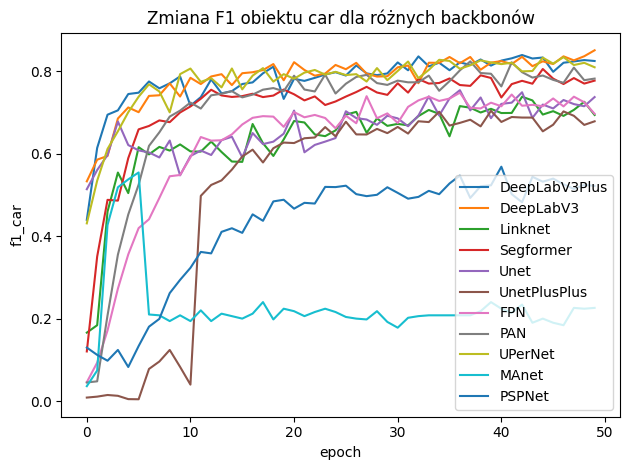

['DeepLabV3Plus', 'DeepLabV3', 'Linknet', 'Segformer', 'Unet', 'UnetPlusPlus', 'FPN', 'PAN', 'UPerNet', 'DPT', 'MAnet', 'PSPNet']


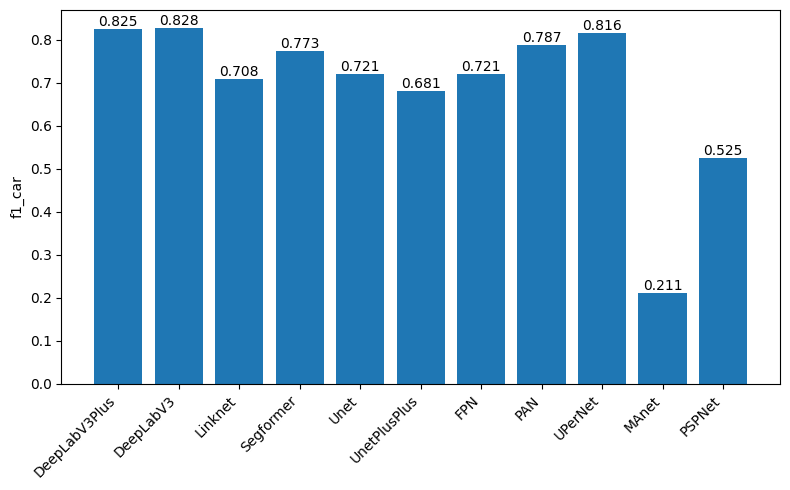

['DeepLabV3Plus', 'DeepLabV3', 'Linknet', 'Segformer', 'Unet', 'UnetPlusPlus', 'FPN', 'PAN', 'UPerNet', 'DPT', 'MAnet', 'PSPNet']


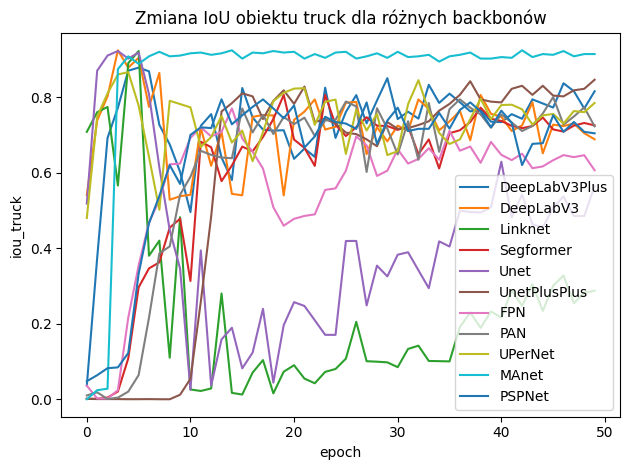

['DeepLabV3Plus', 'DeepLabV3', 'Linknet', 'Segformer', 'Unet', 'UnetPlusPlus', 'FPN', 'PAN', 'UPerNet', 'DPT', 'MAnet', 'PSPNet']


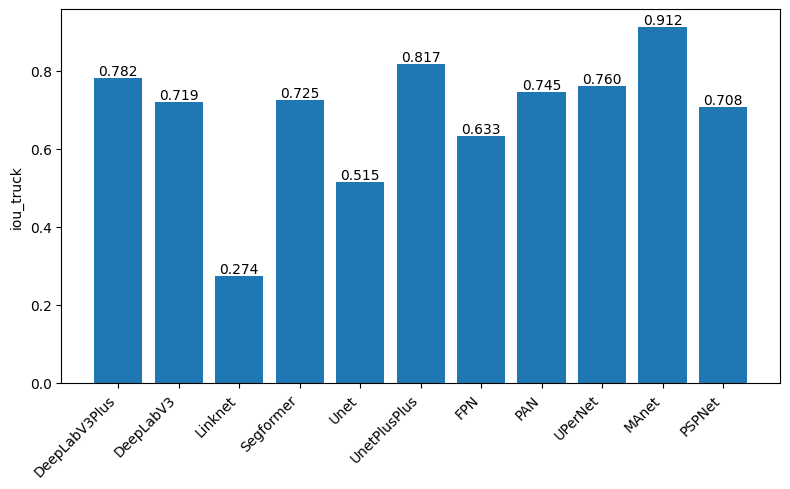

['DeepLabV3Plus', 'DeepLabV3', 'Linknet', 'Segformer', 'Unet', 'UnetPlusPlus', 'FPN', 'PAN', 'UPerNet', 'DPT', 'MAnet', 'PSPNet']


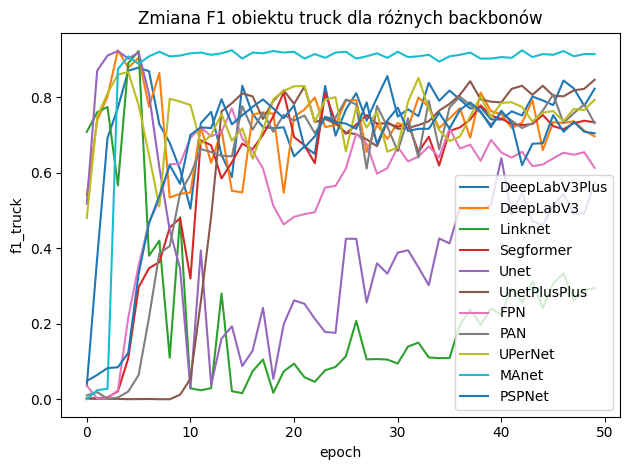

['DeepLabV3Plus', 'DeepLabV3', 'Linknet', 'Segformer', 'Unet', 'UnetPlusPlus', 'FPN', 'PAN', 'UPerNet', 'DPT', 'MAnet', 'PSPNet']


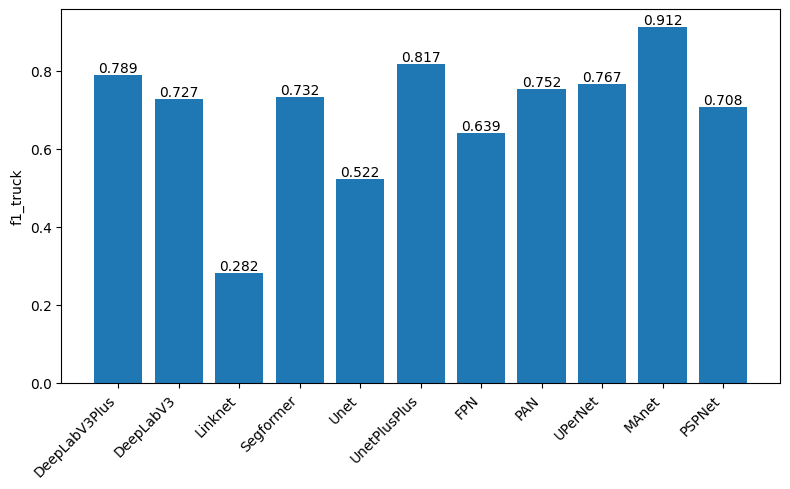

In [3]:
backbones_initial = [
    'DeepLabV3Plus', 'DeepLabV3', 'Linknet', 'Segformer', 'Unet', 'UnetPlusPlus', 'FPN', 'PAN', 'UPerNet', 'DPT', 'MAnet', 'PSPNet'
    ]

for metrics in comparision_metrics:
    draw_backbone_comparision_plot(
        title=metrics[0],
        y_metric=metrics[1],
        metrics_files=get_metrics_files(logs_root, backbones_initial)
    )
    
    visualize_accumulated(
        metrics_files=get_metrics_files(logs_root, backbones_initial),
        y_metric=metrics[1]
    )

### Eksperyment na wybranych sieciach

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


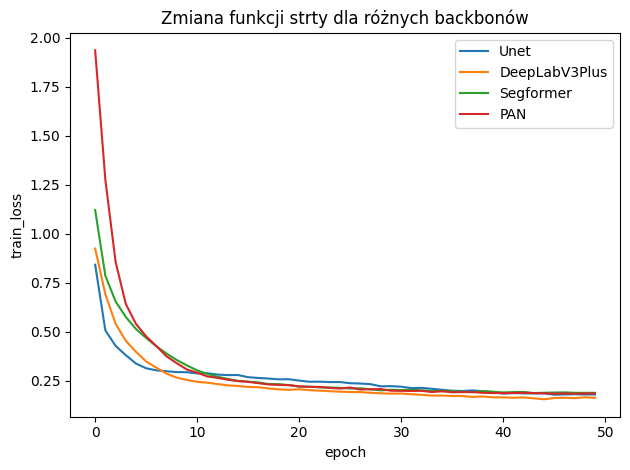

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


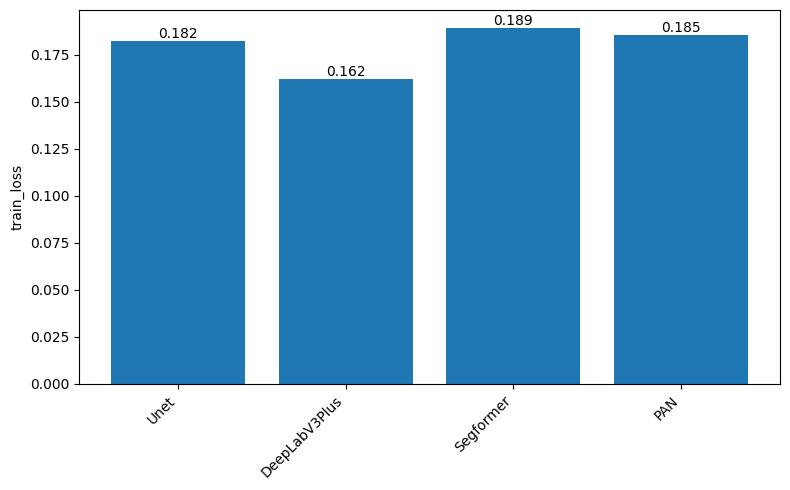

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


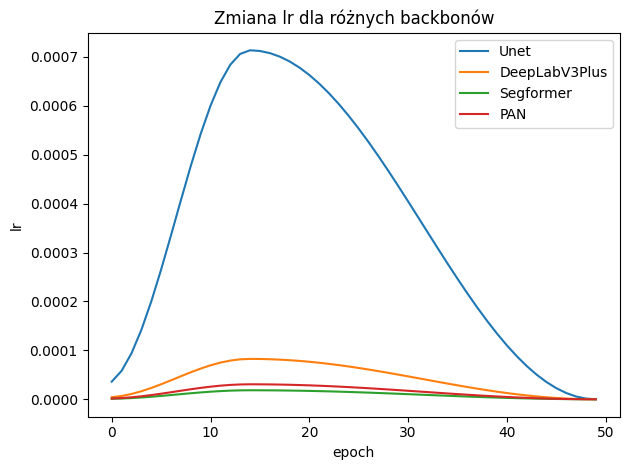

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


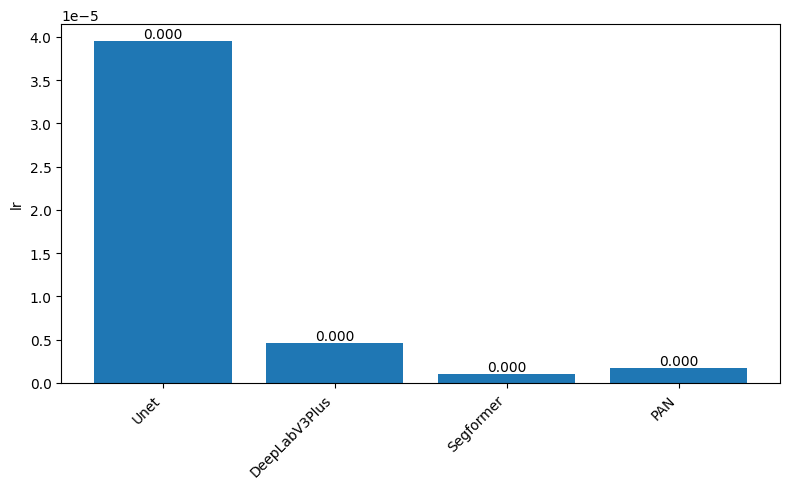

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


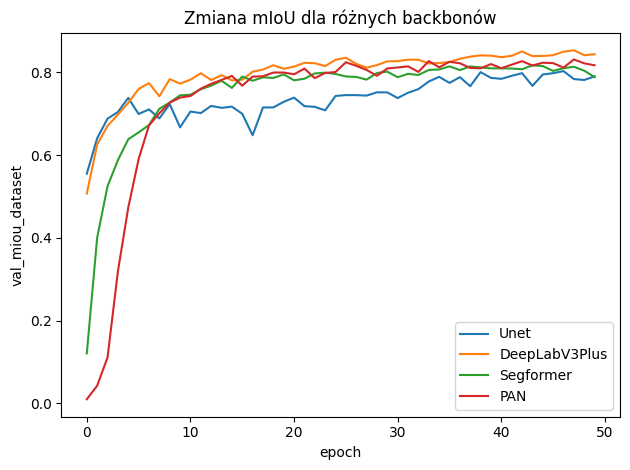

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


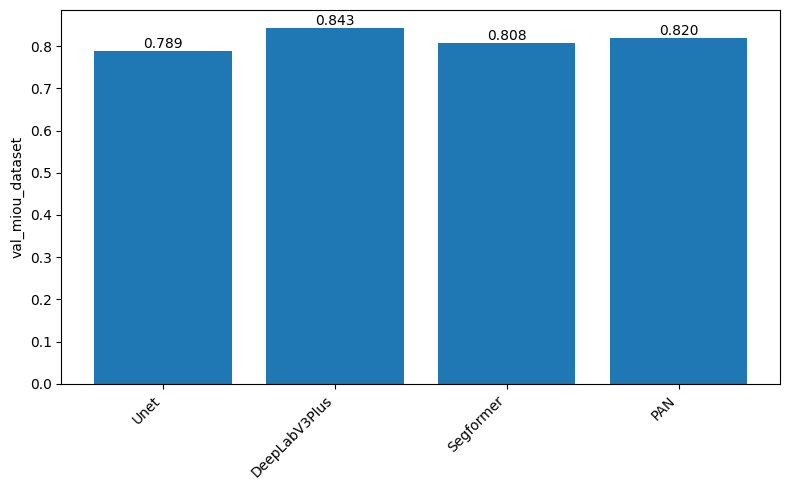

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


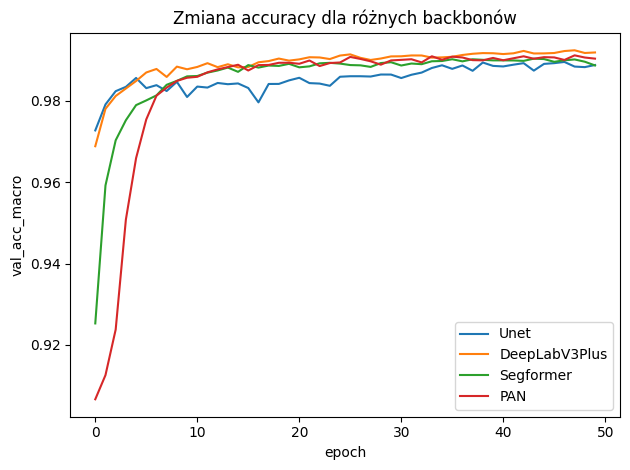

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


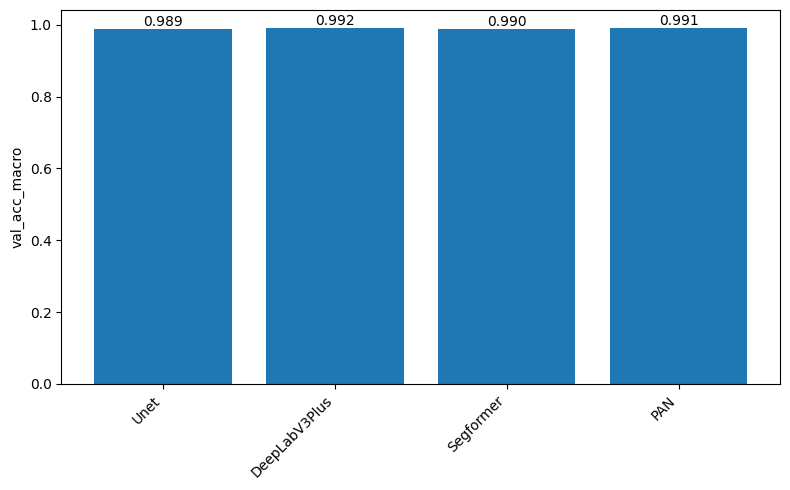

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


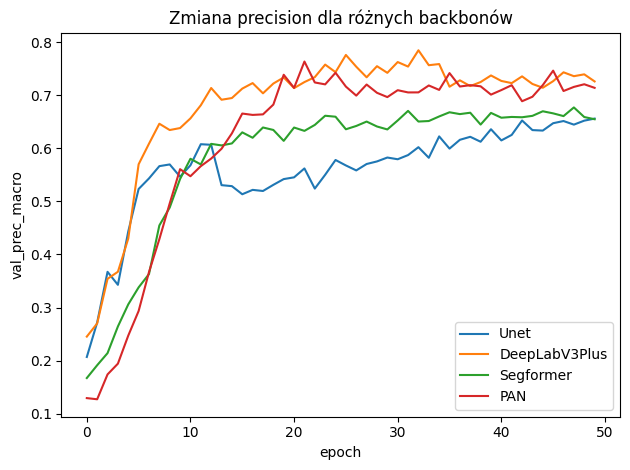

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


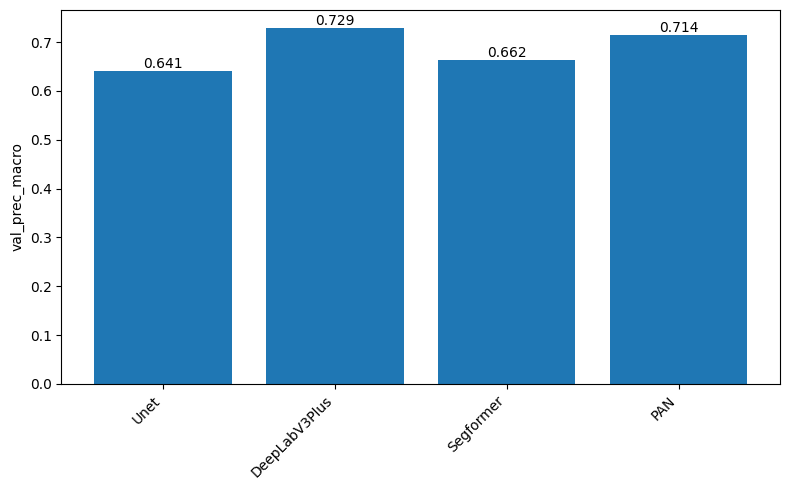

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


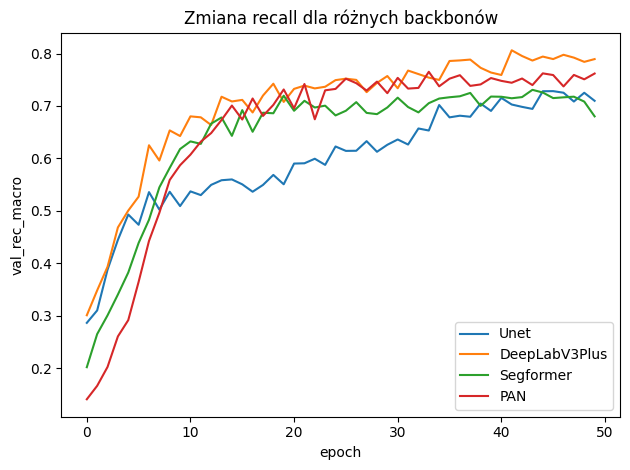

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


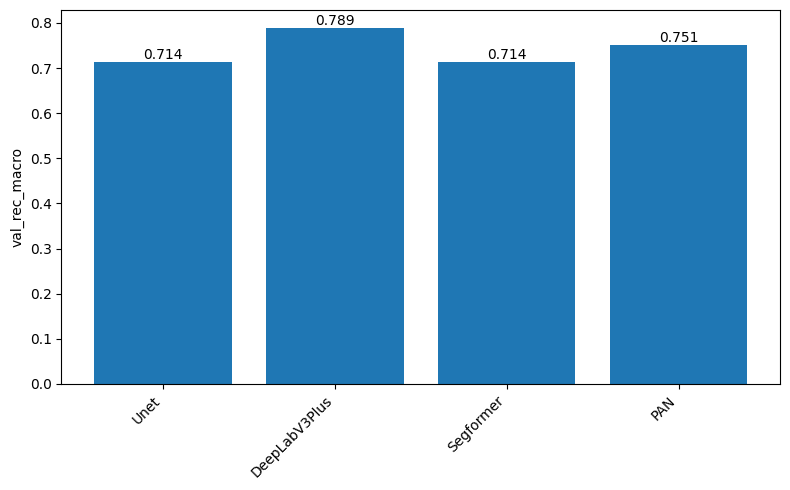

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


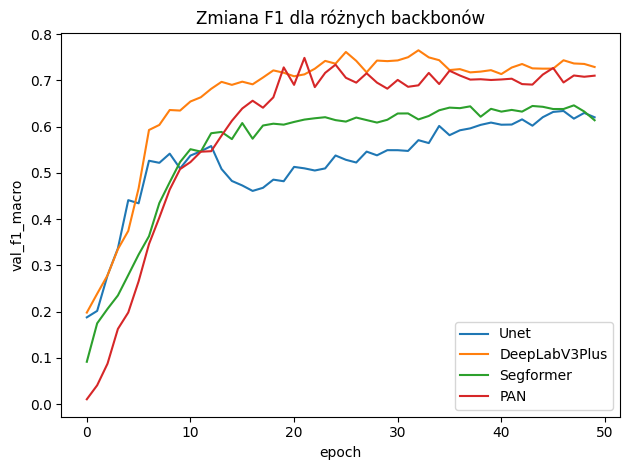

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


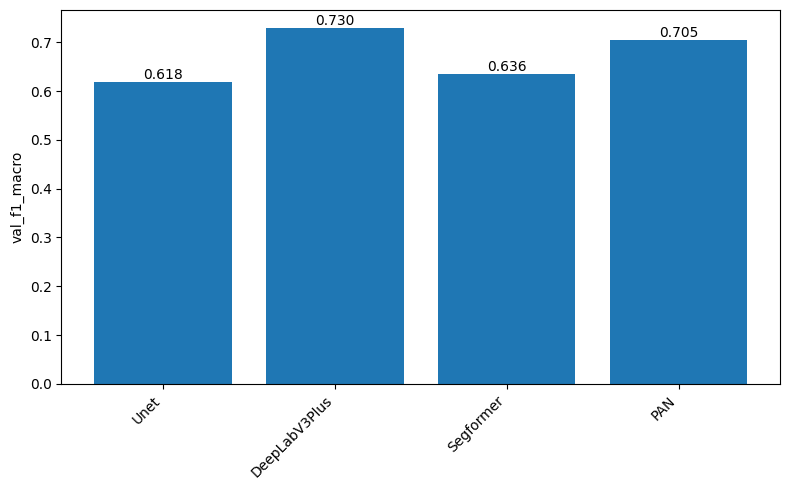

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


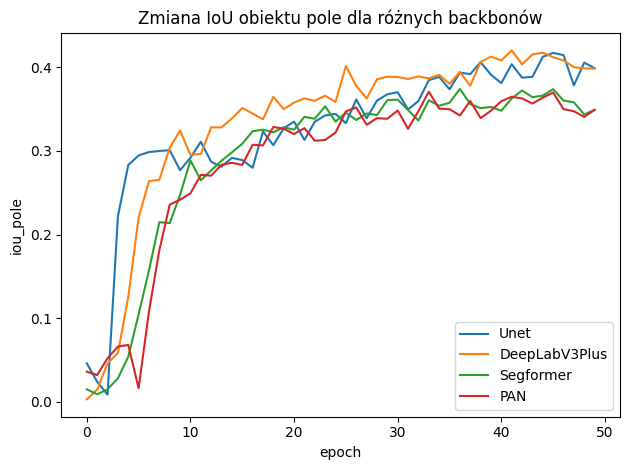

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


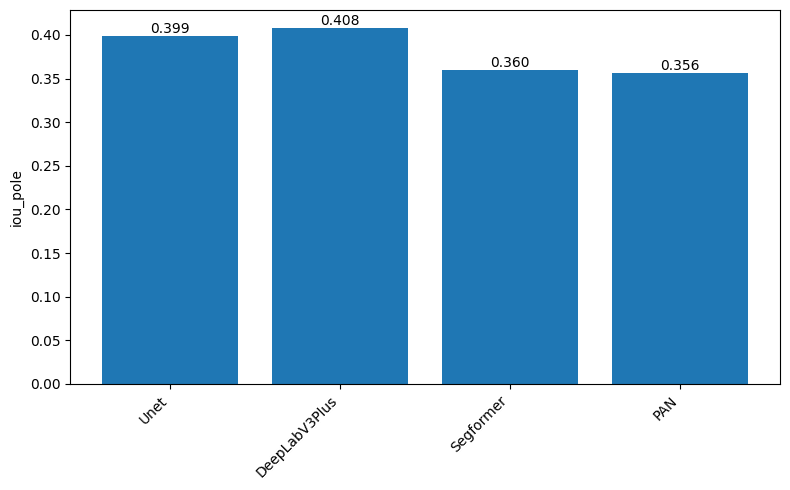

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


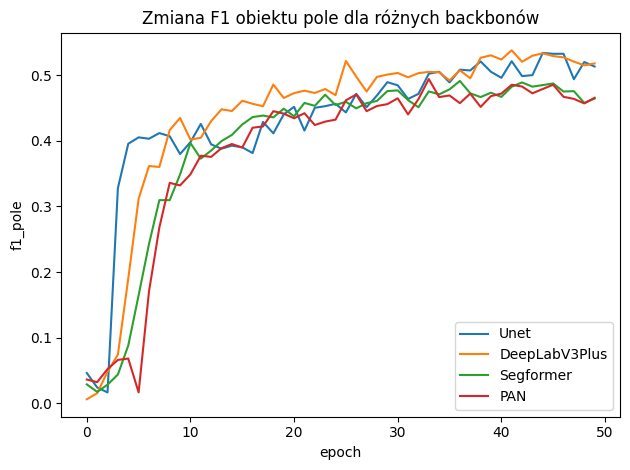

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


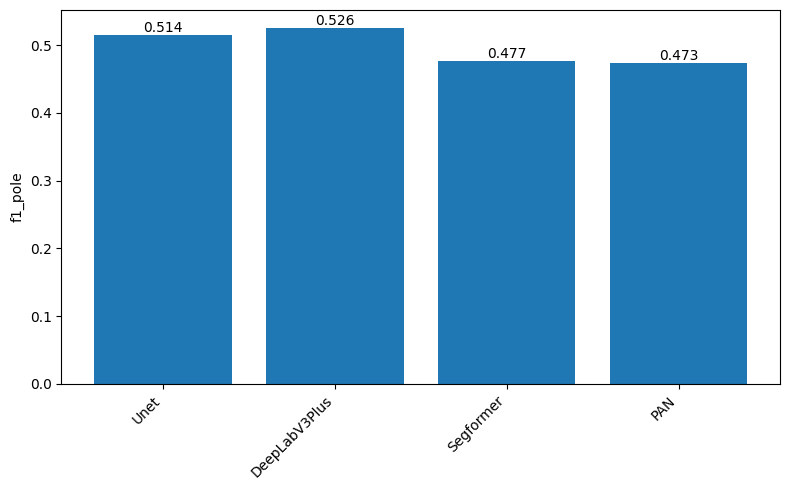

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


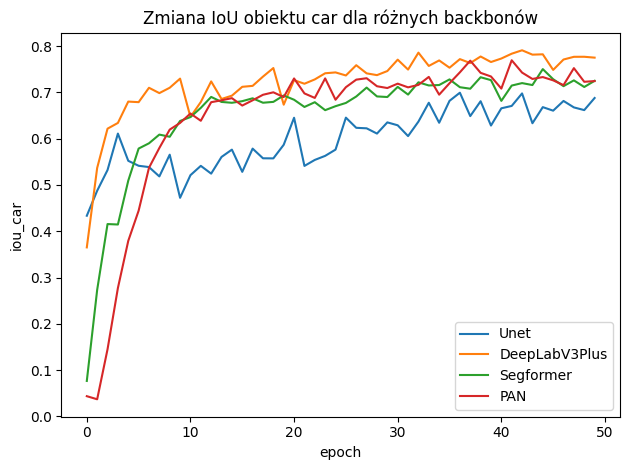

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


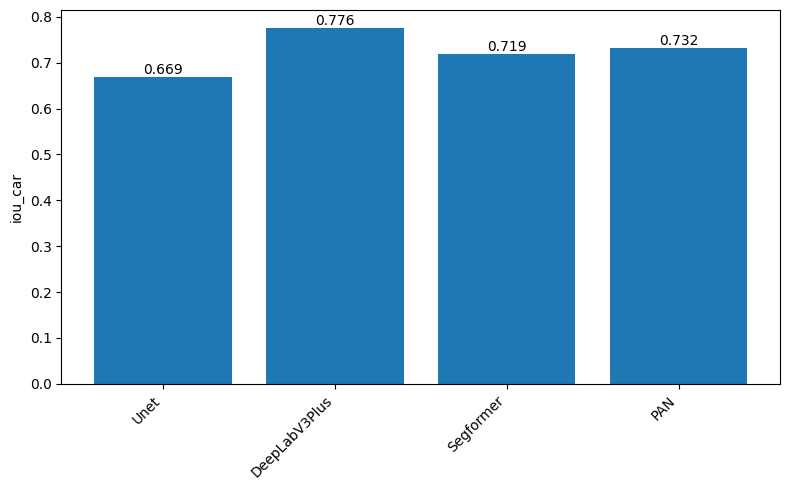

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


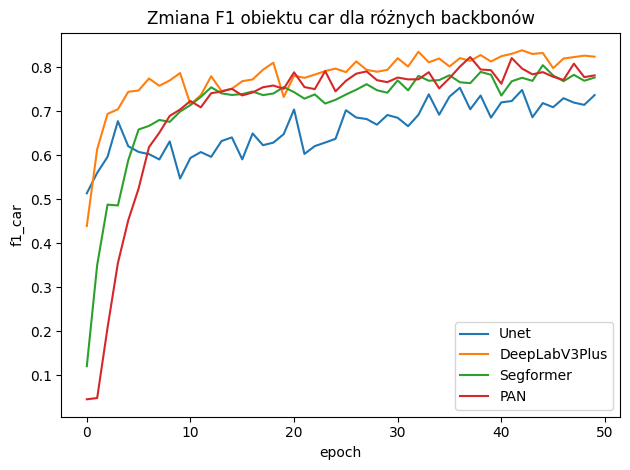

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


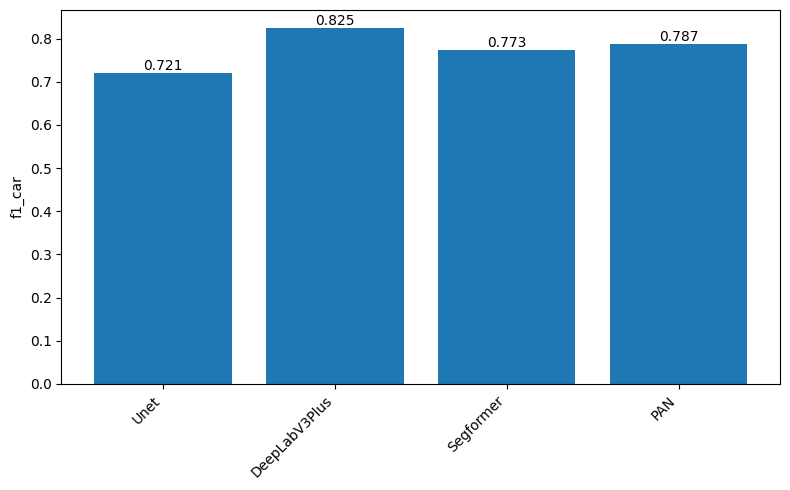

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


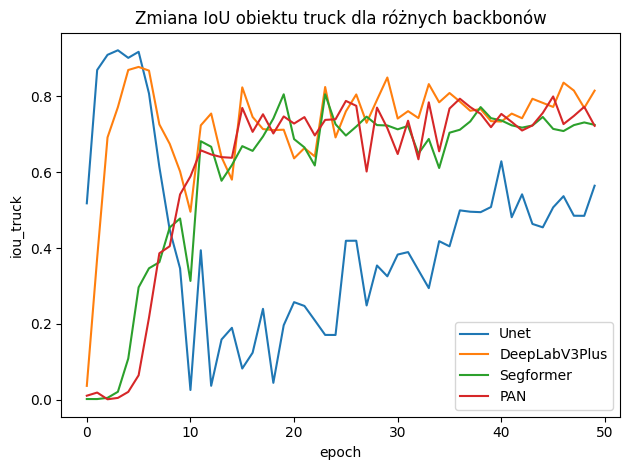

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


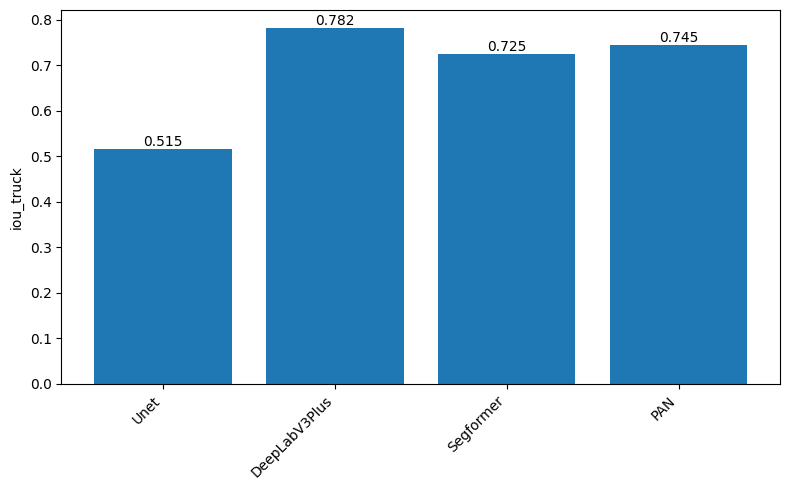

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


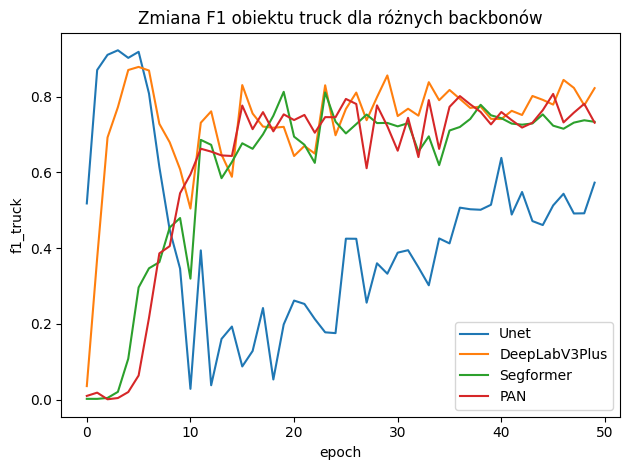

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


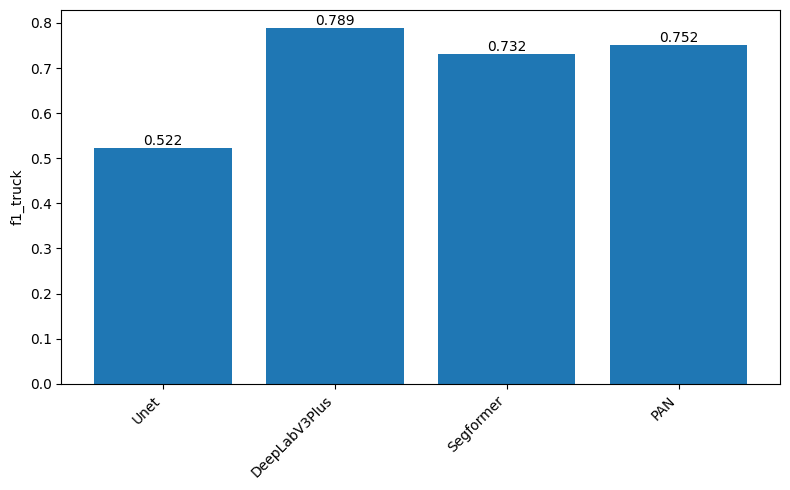

In [4]:
backbones_final = [
    'Unet', 'DeepLabV3Plus', 'Segformer', 'PAN'
    ]

for metrics in comparision_metrics:
    draw_backbone_comparision_plot(
        title=metrics[0],
        y_metric=metrics[1],
        metrics_files=get_metrics_files(logs_root, backbones_final)
    )

    visualize_accumulated(
        metrics_files=get_metrics_files(logs_root, backbones_final),
        y_metric=metrics[1]
    )

## Porównanie enkoderów 

Na tym etapie porównane zostały enkodery warstwy wejściowej, które służą do rozpoznawania obiektów na obrazie. Wybrane zostały 3 najbardziej interesujące wyniki oraz wyłoniony został enkoder, który daje zadowalające wyniki.

### Eksperyment wstępny

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


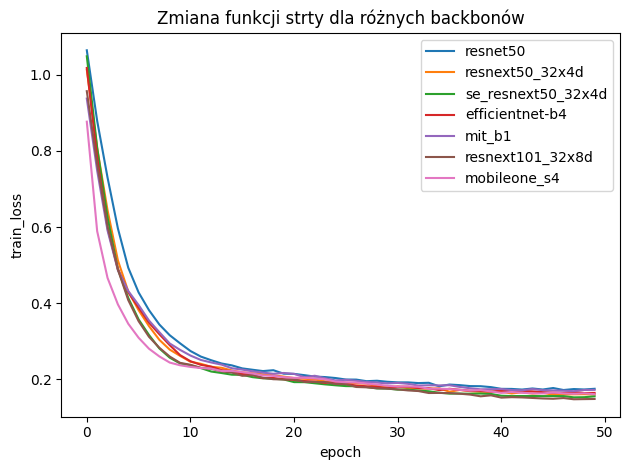

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


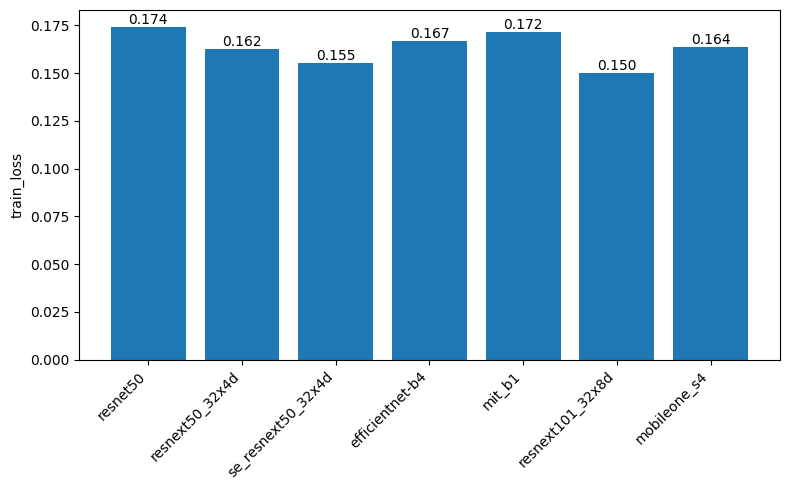

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


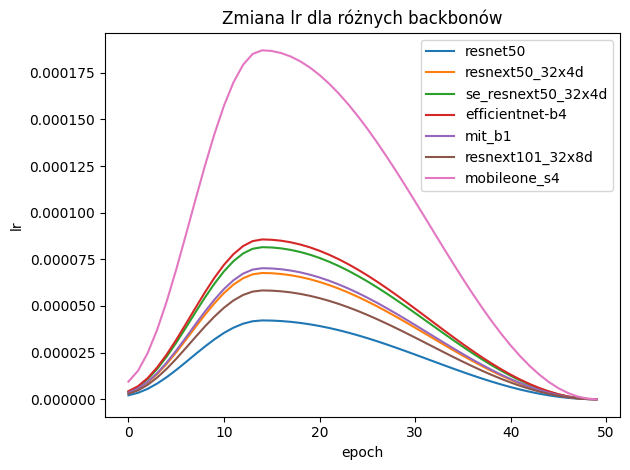

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


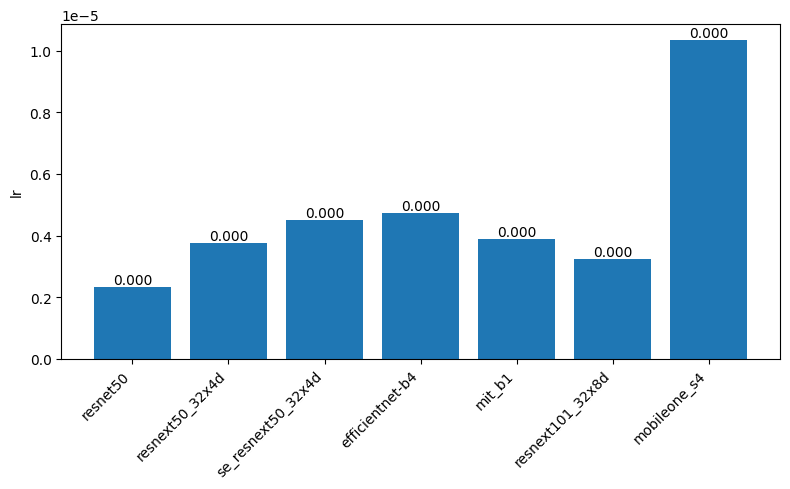

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


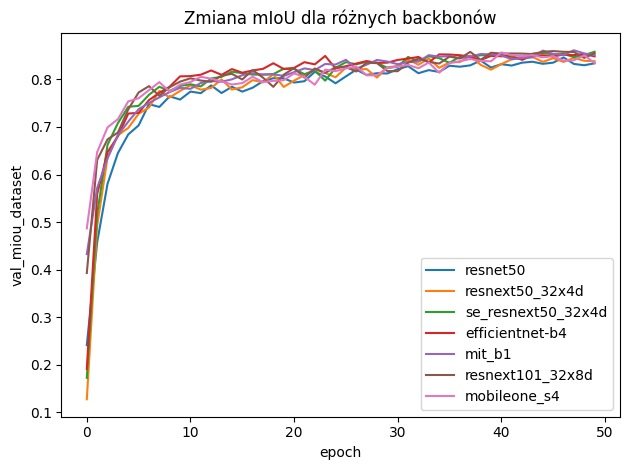

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


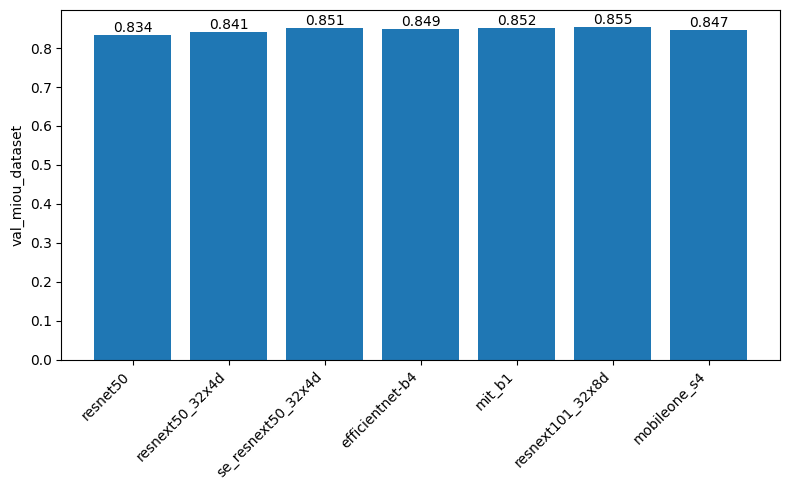

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


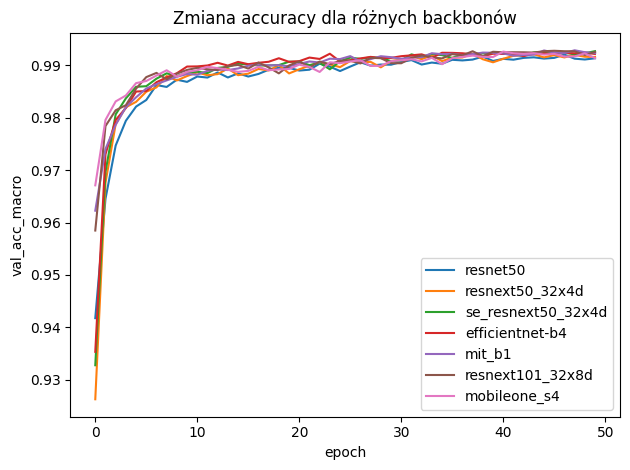

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


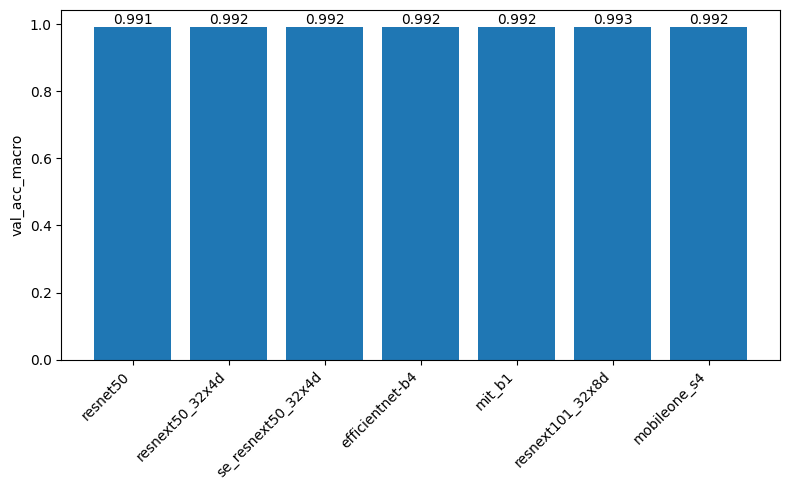

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


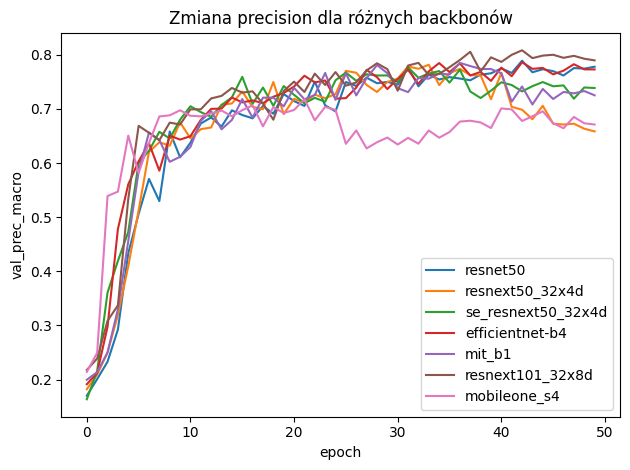

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


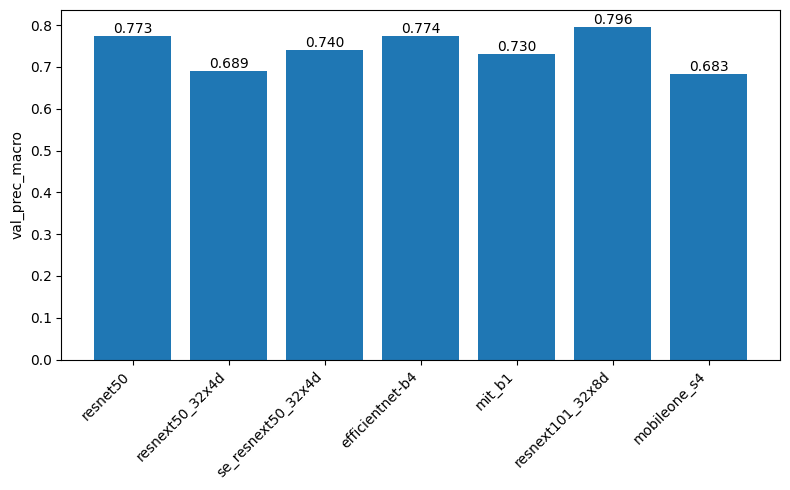

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


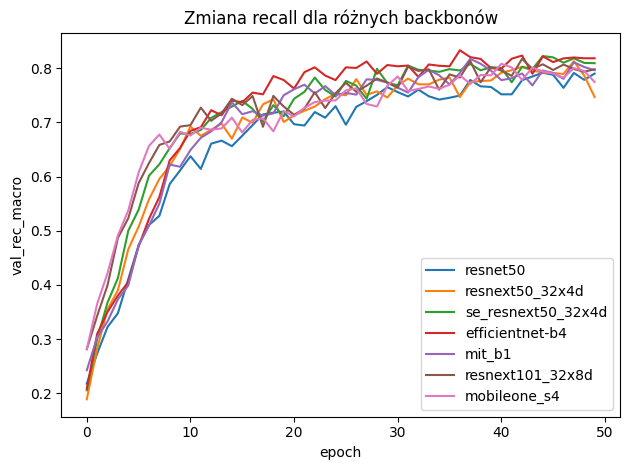

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


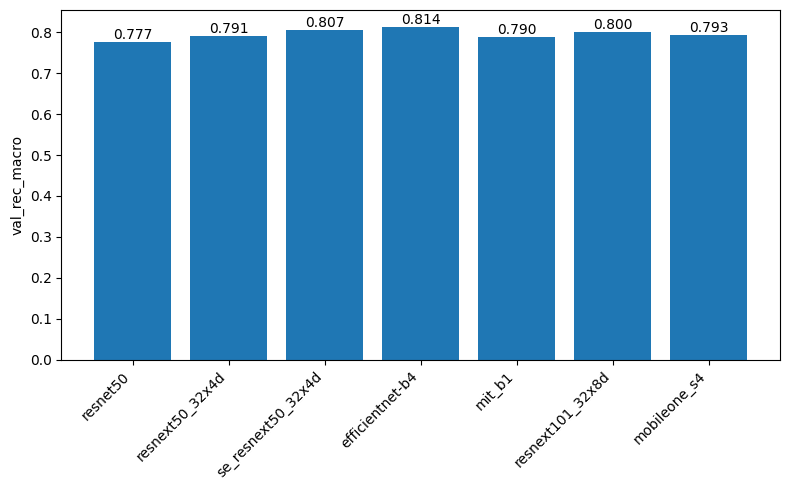

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


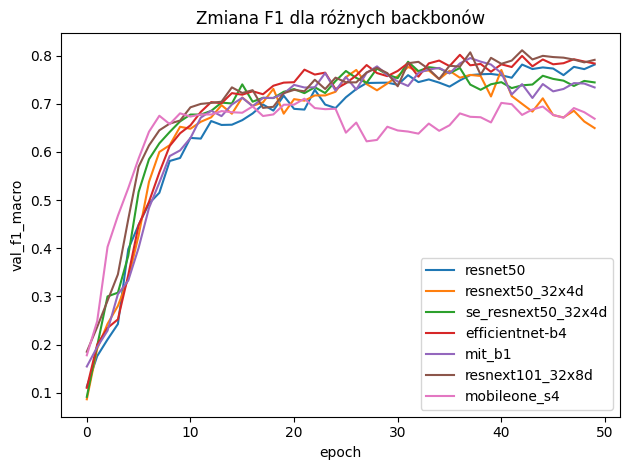

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


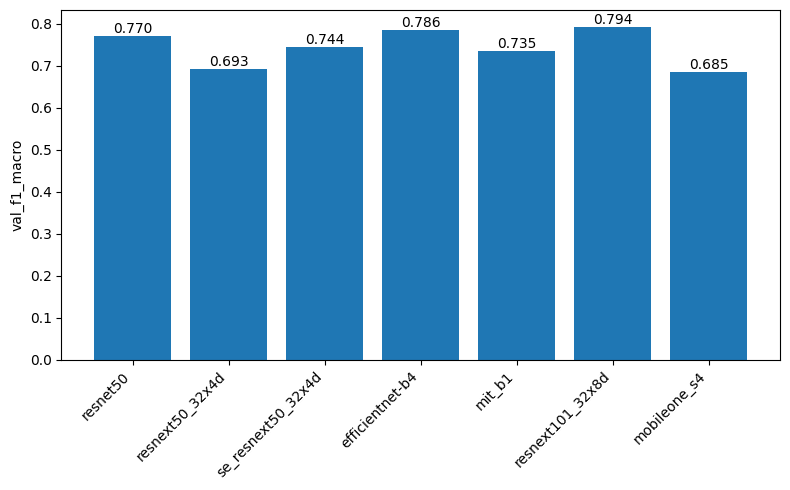

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


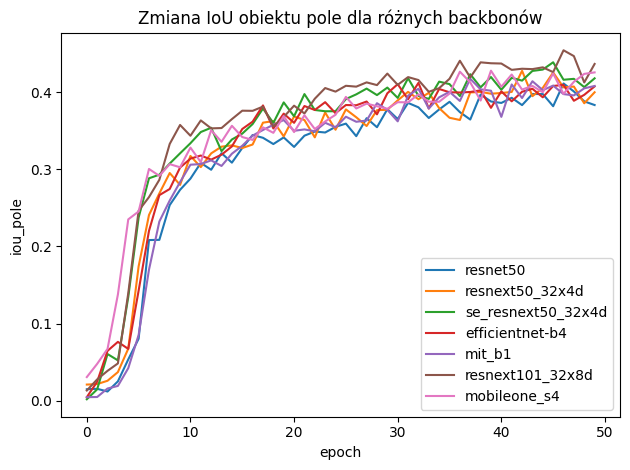

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


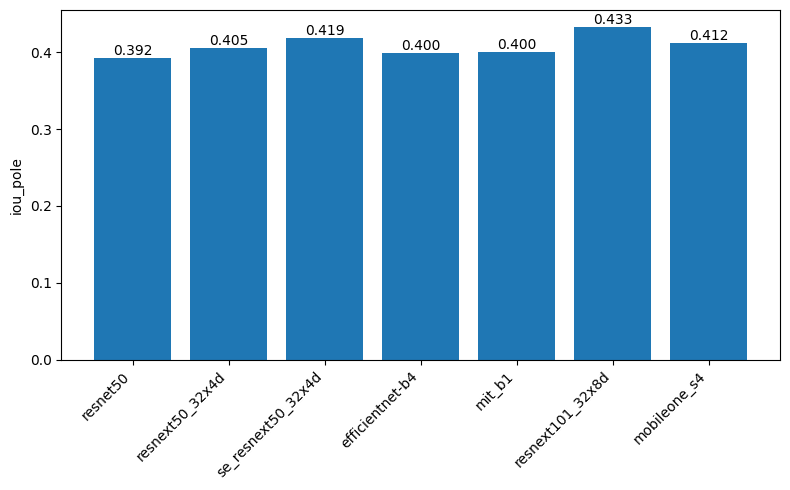

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


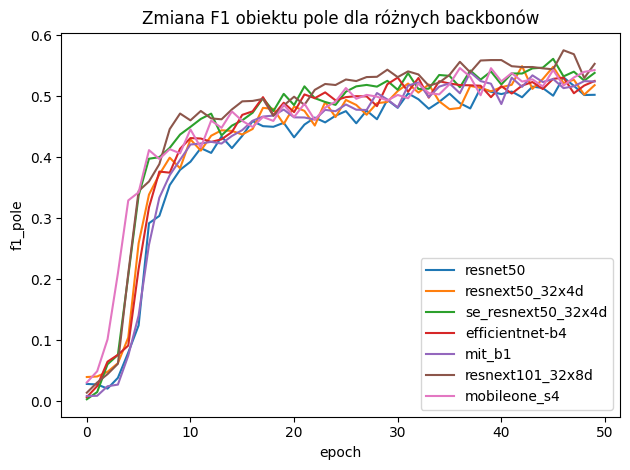

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


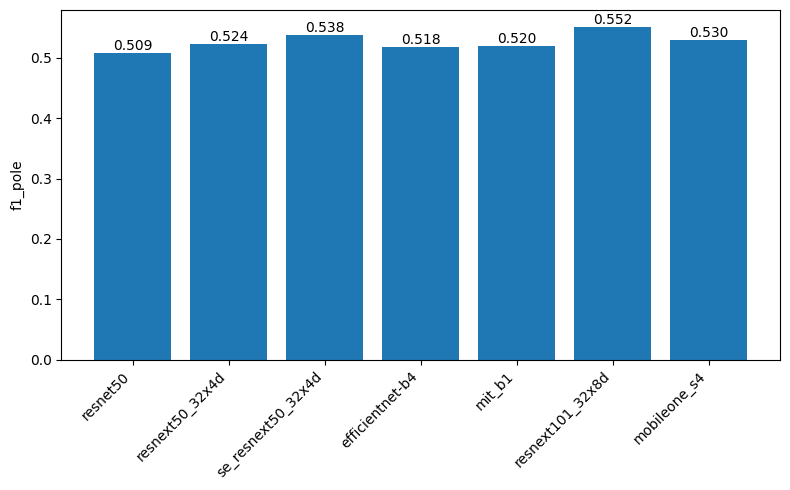

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


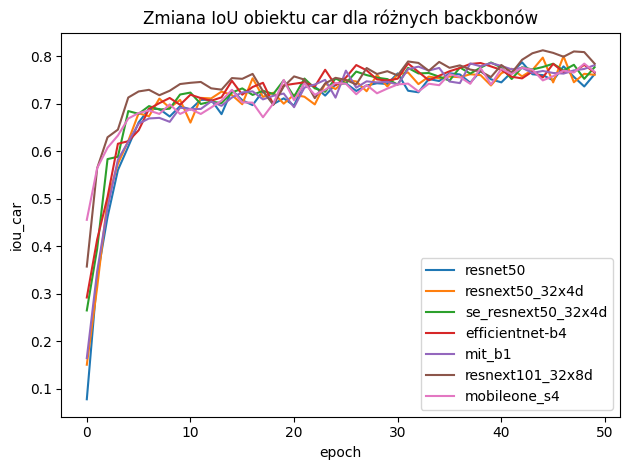

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


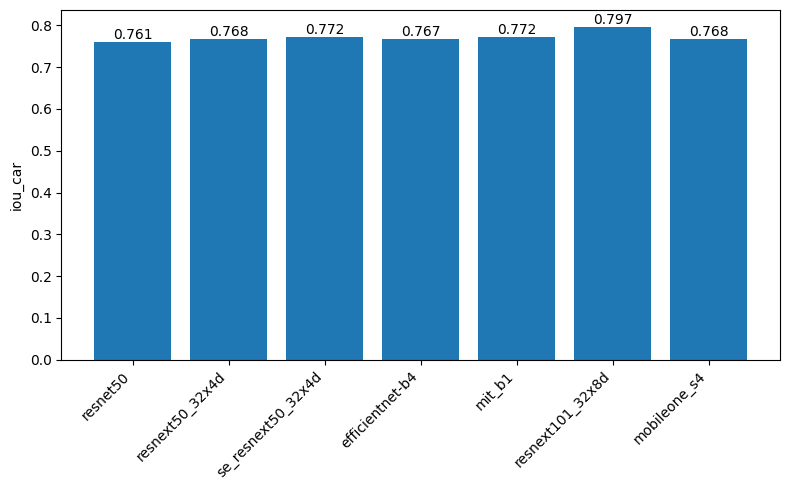

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


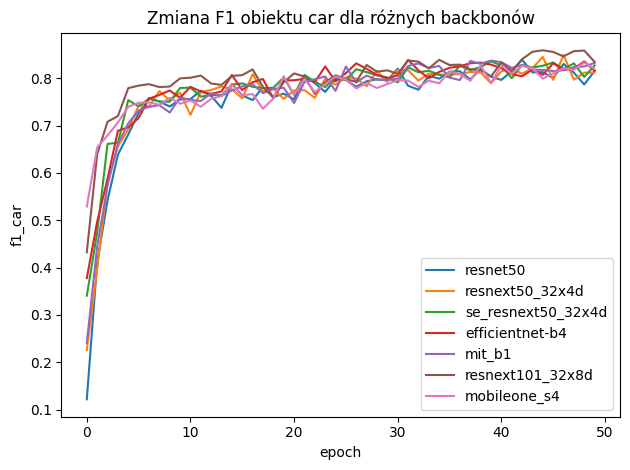

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


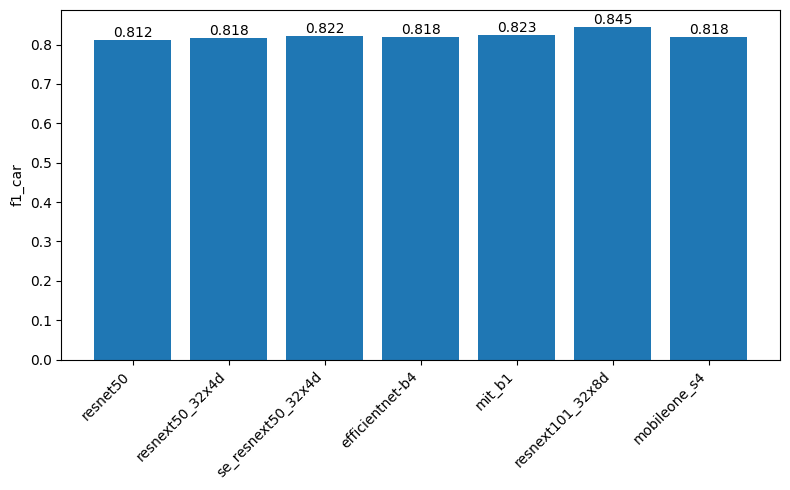

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


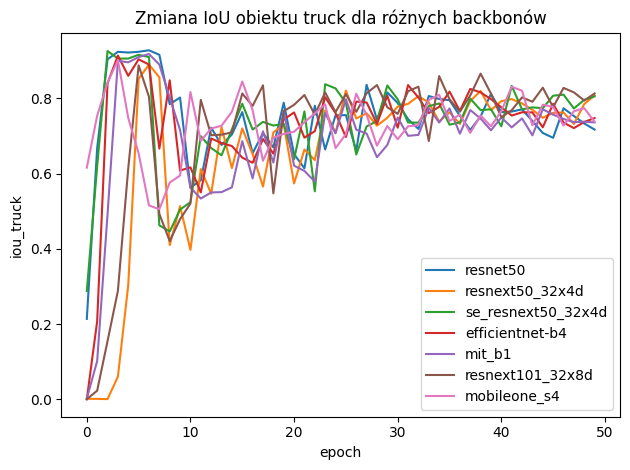

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


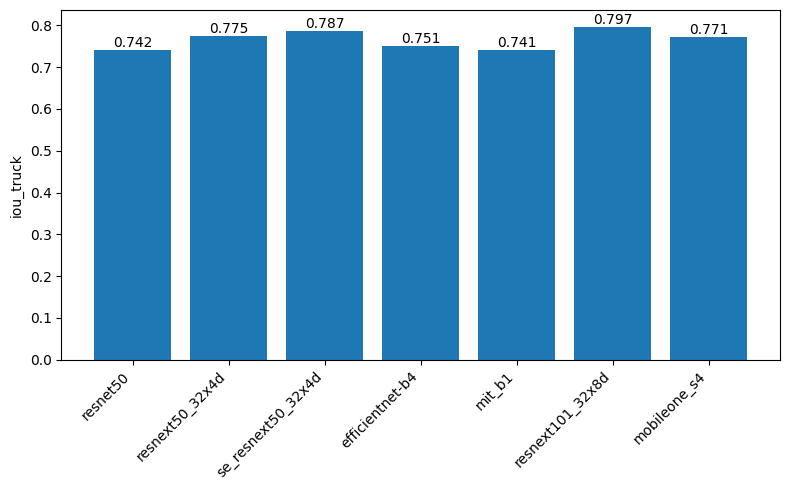

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


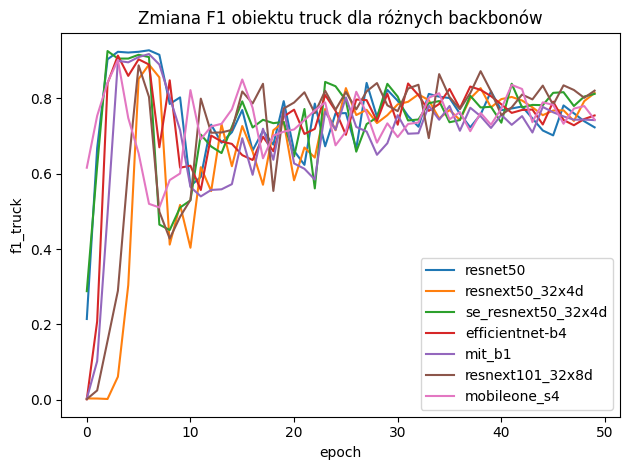

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


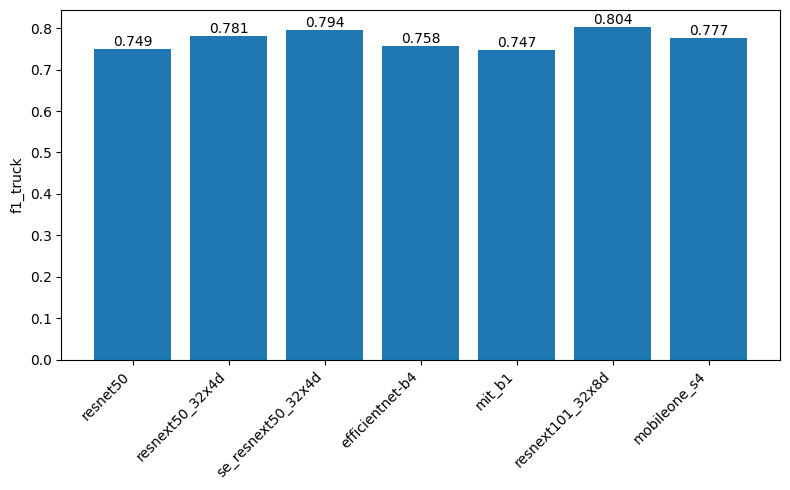

In [5]:
import matplotlib.pyplot as plt

logs_root = ".\\checkpoints\\stage2"

for metrics in comparision_metrics:
    draw_backbone_comparision_plot(
        title=metrics[0],
        y_metric=metrics[1],
        metrics_files=get_metrics_files(logs_root, backbones_final),
        subject='encoder'
    )

    visualize_accumulated(
        metrics_files=get_metrics_files(logs_root, backbones_final),
        y_metric=metrics[1],
        subject='encoder'
    )
    

### Eksperyment na wybranych enkoderach

['DeepLabV3Plus']


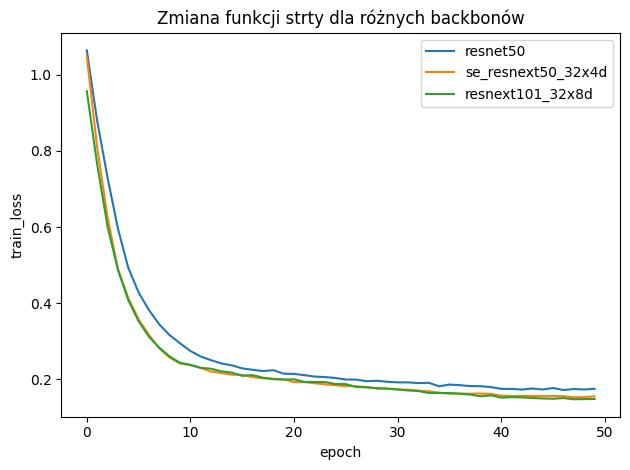

['DeepLabV3Plus']


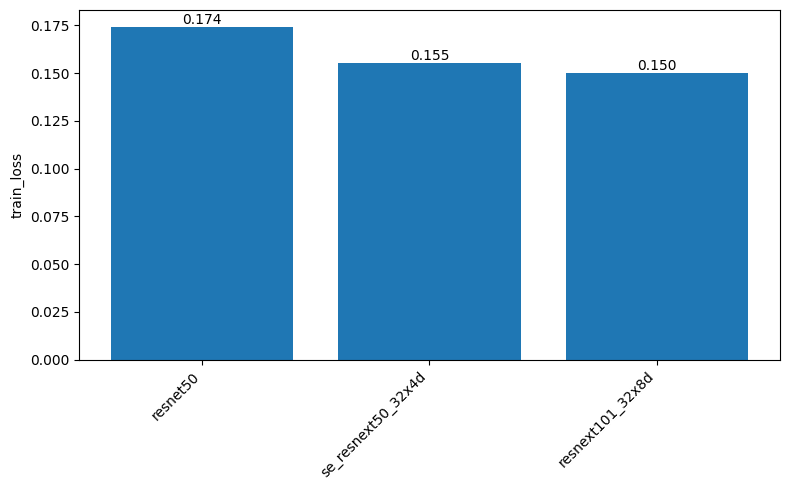

['DeepLabV3Plus']


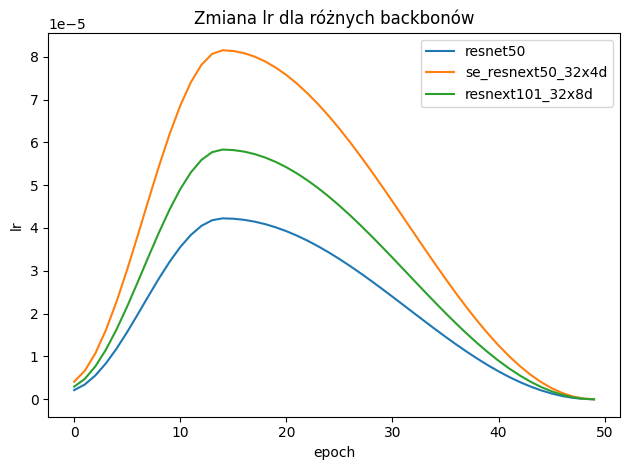

['DeepLabV3Plus']


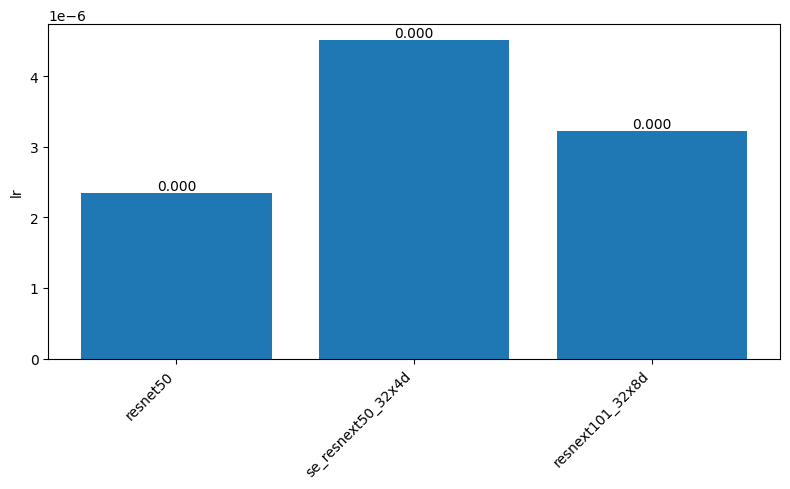

['DeepLabV3Plus']


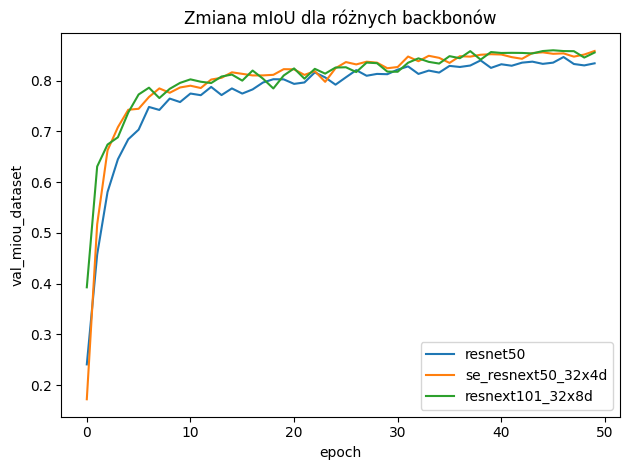

['DeepLabV3Plus']


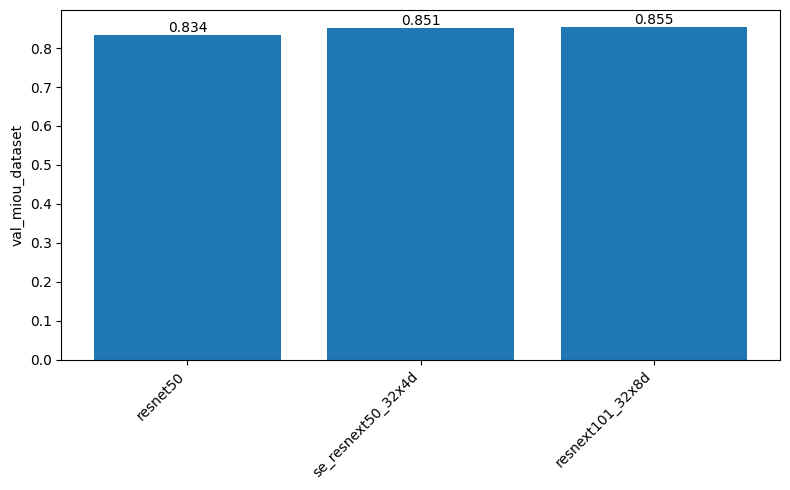

['DeepLabV3Plus']


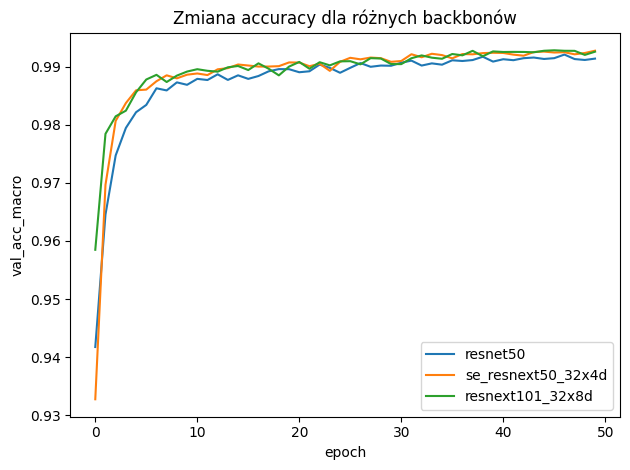

['DeepLabV3Plus']


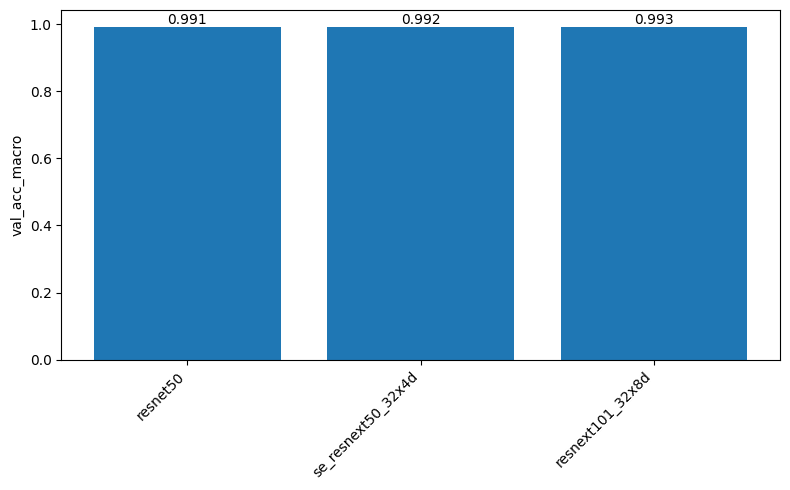

['DeepLabV3Plus']


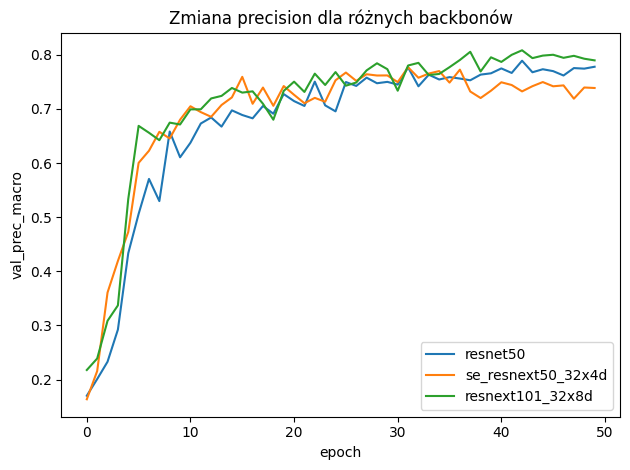

['DeepLabV3Plus']


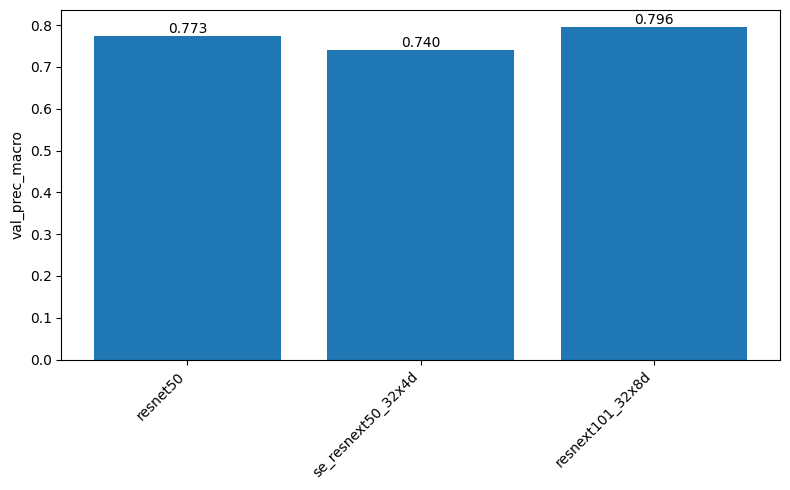

['DeepLabV3Plus']


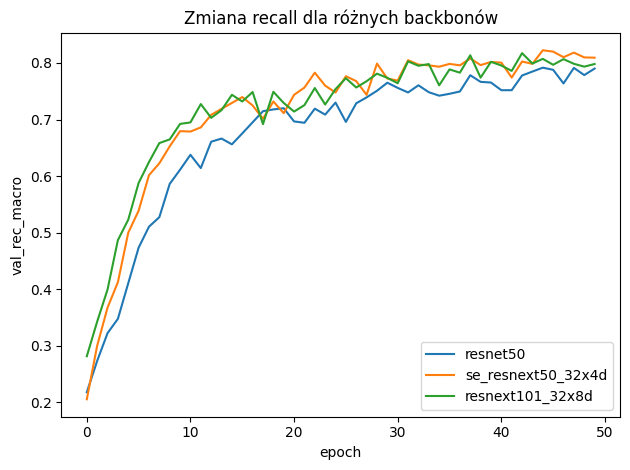

['DeepLabV3Plus']


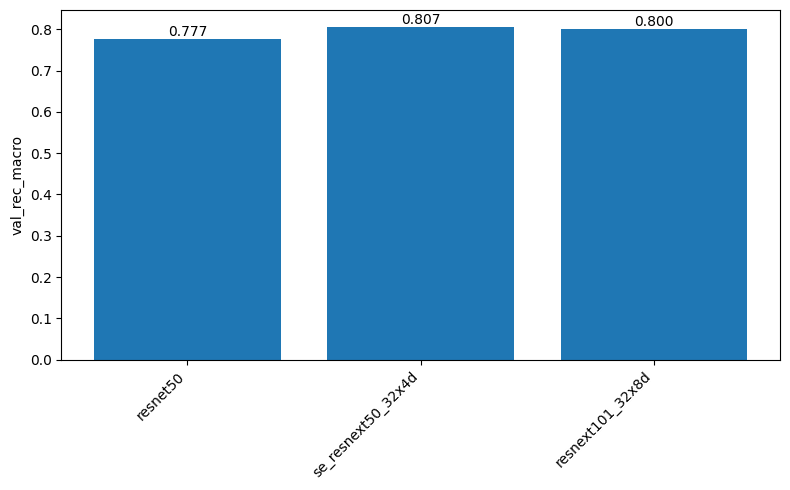

['DeepLabV3Plus']


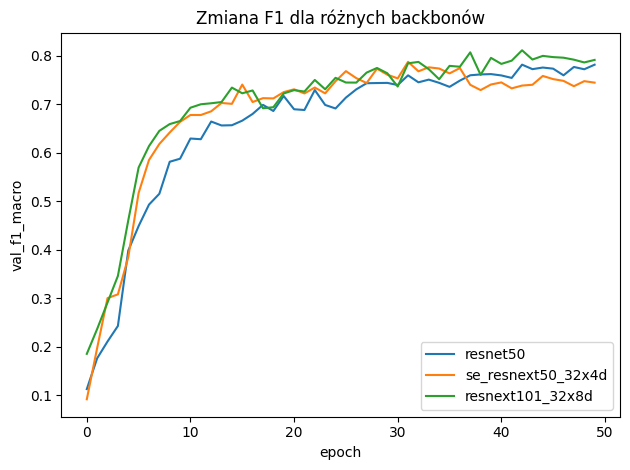

['DeepLabV3Plus']


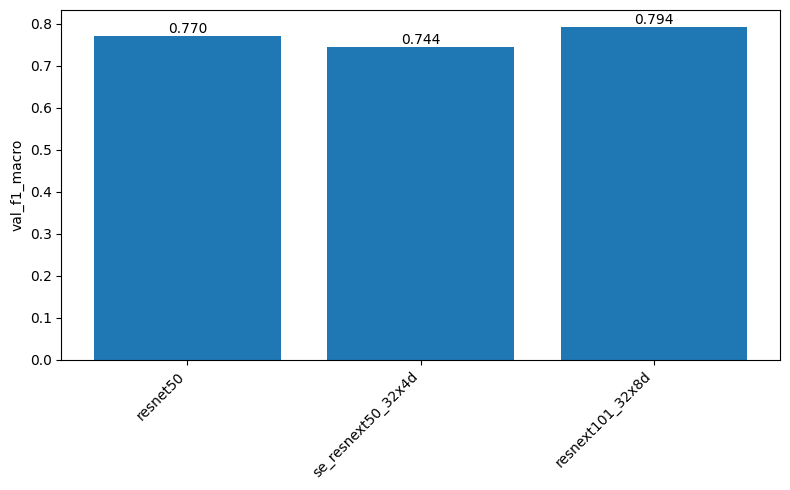

['DeepLabV3Plus']


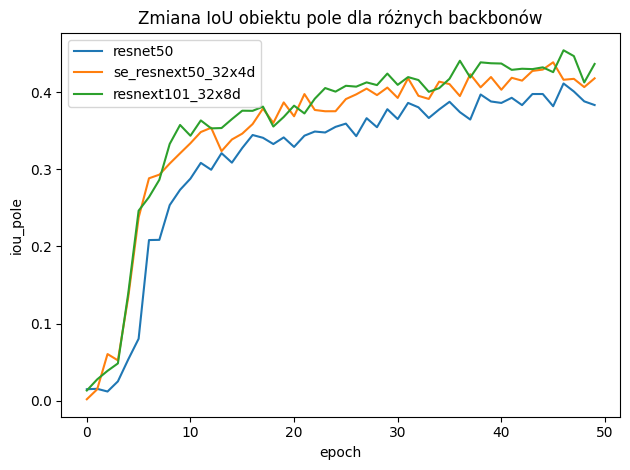

['DeepLabV3Plus']


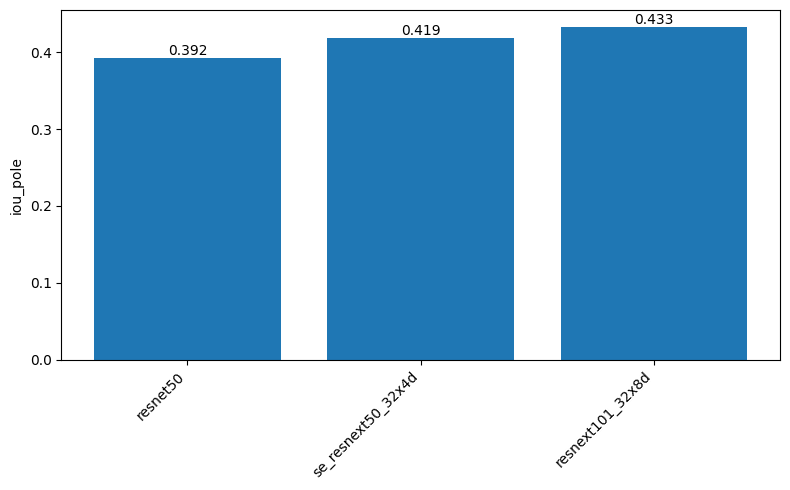

['DeepLabV3Plus']


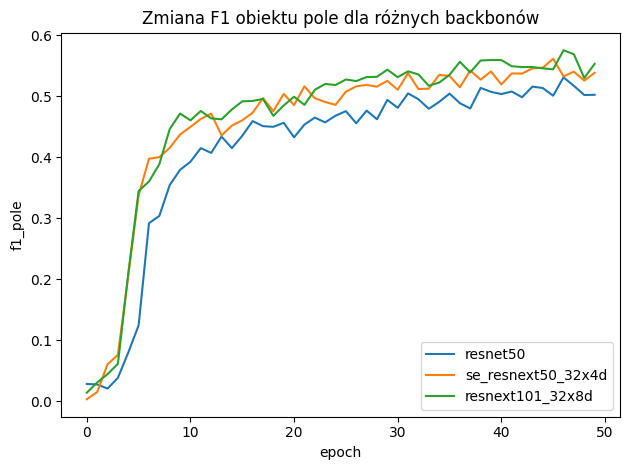

['DeepLabV3Plus']


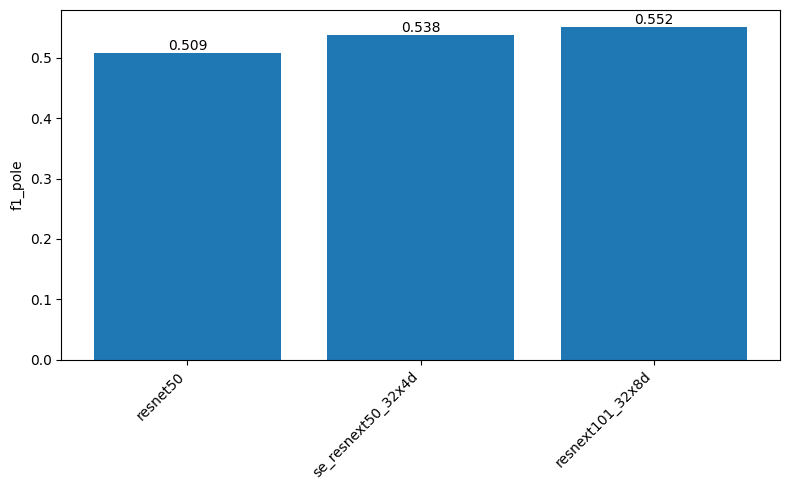

['DeepLabV3Plus']


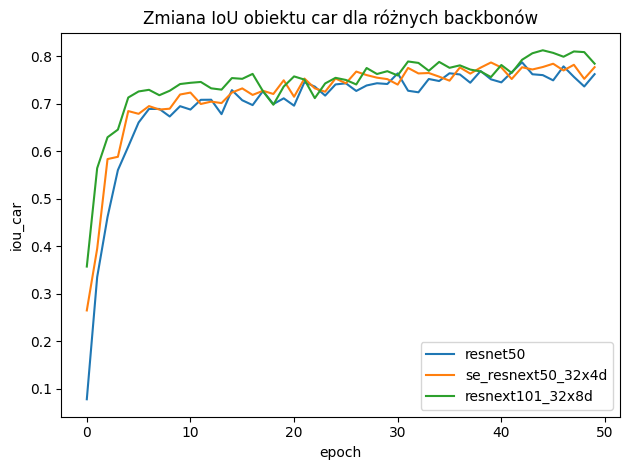

['DeepLabV3Plus']


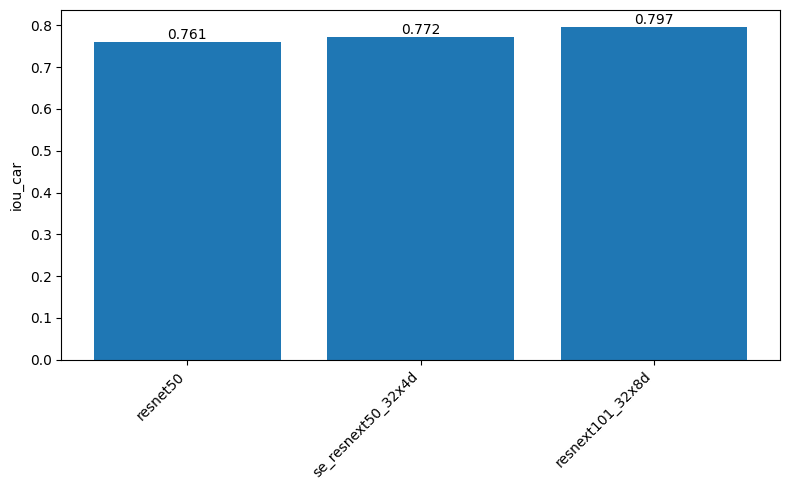

['DeepLabV3Plus']


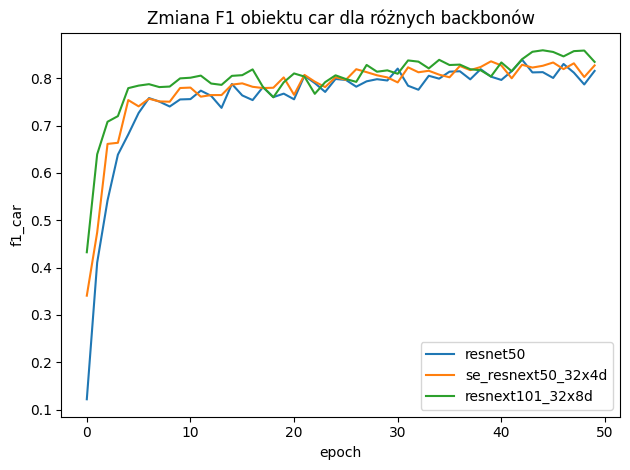

['DeepLabV3Plus']


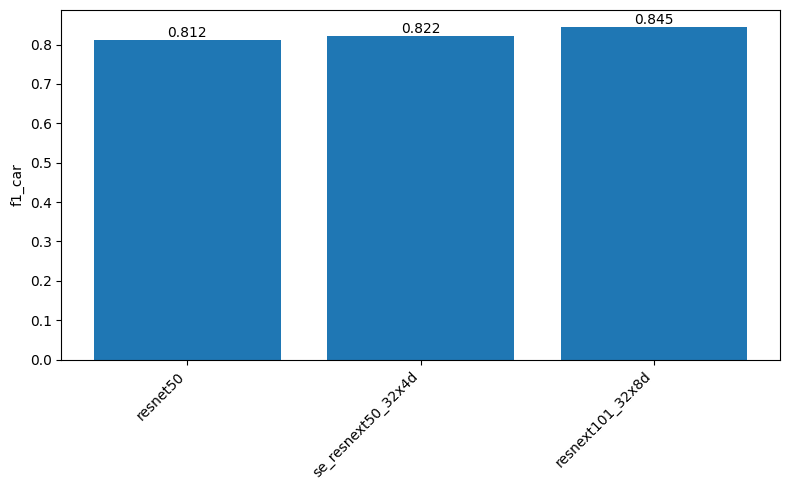

['DeepLabV3Plus']


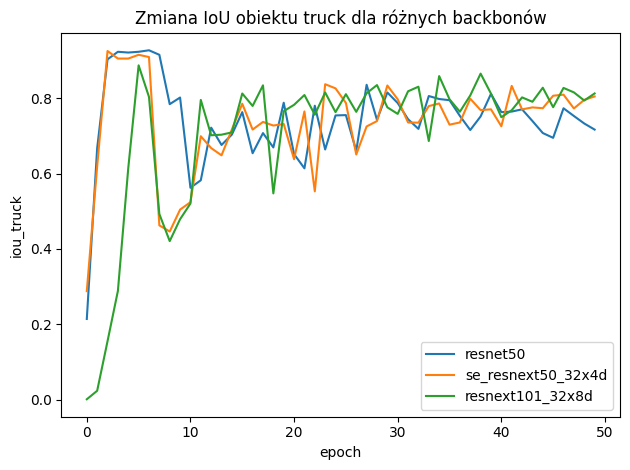

['DeepLabV3Plus']


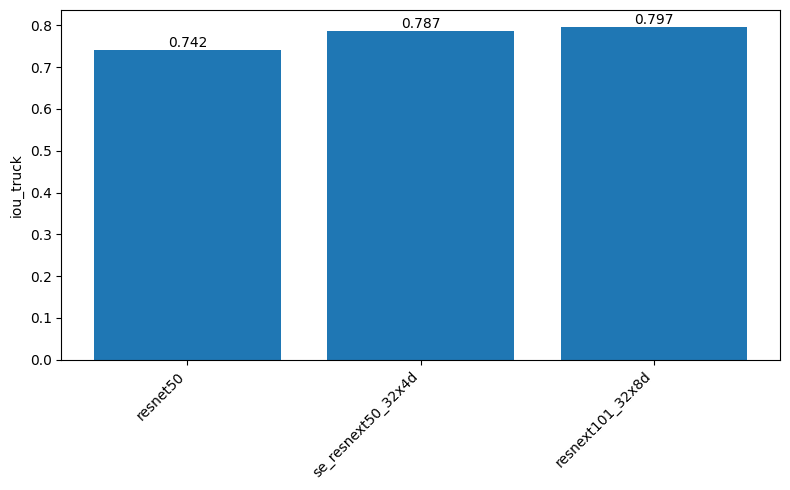

['DeepLabV3Plus']


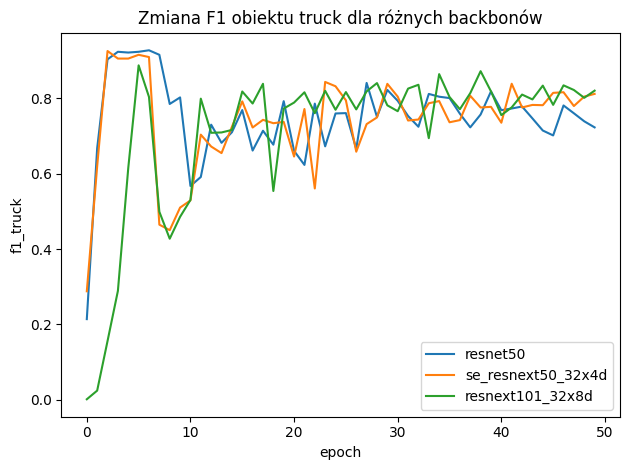

['DeepLabV3Plus']


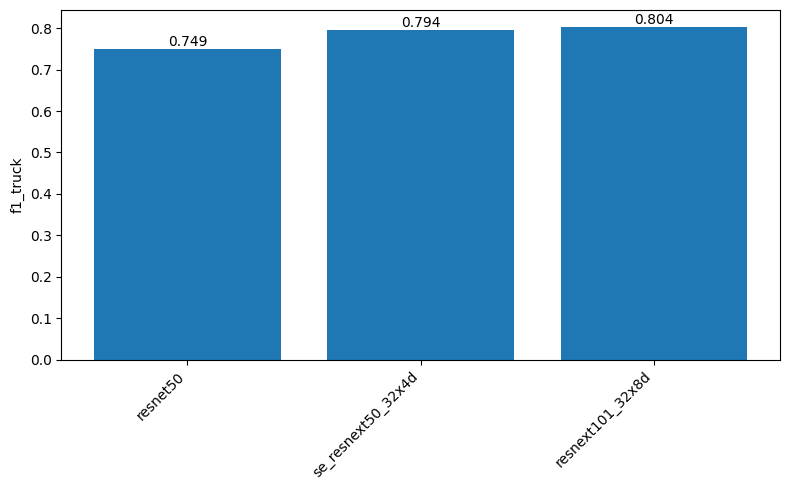

In [6]:
encoders_final = [
    'resnet50', 'se_resnext50_32x4d', 'resnext101_32x8d'
]

for metrics in comparision_metrics:
    draw_backbone_comparision_plot(
        title=metrics[0],
        y_metric=metrics[1],
        metrics_files=get_metrics_files(logs_root, encoders=encoders_final),
        subject='encoder'
    )

    visualize_accumulated(
        metrics_files=get_metrics_files(logs_root, encoders=encoders_final),
        y_metric=metrics[1],
        subject='encoder'
    )

## Porównanie konfiguracji funkcji straty

Porównane zostały różne konfiguracje funkcji straty, wybrane zostaną 3 najbardziej interesujące oraz ostatecznie wyłoniona zostanie ta, która osiąga najlepsze wyniki.

### Eksperyment wstępny

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


C:\Users\fhcar\AppData\Local\Temp\ipykernel_28404\2846584638.py:60: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(metrics[x_metric], metrics[y_metric], label=get_metadata_field(metadata, subject))
C:\Users\fhcar\AppData\Local\Temp\ipykernel_28404\2846584638.py:60: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(metrics[x_metric], metrics[y_metric], label=get_metadata_field(metadata, subject))
C:\Users\fhcar\AppData\Local\Temp\ipykernel_28404\2846584638.py:60: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.

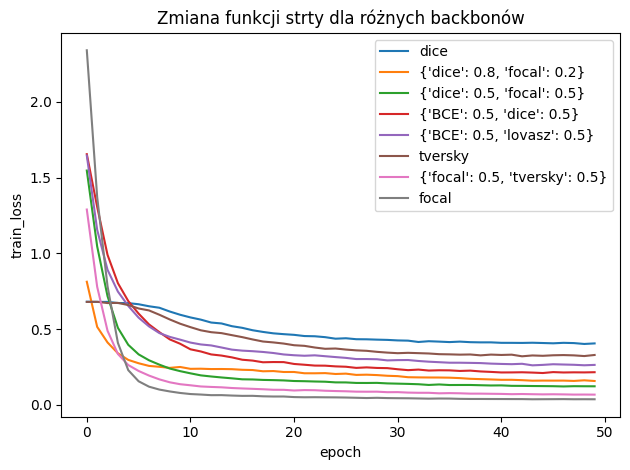

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


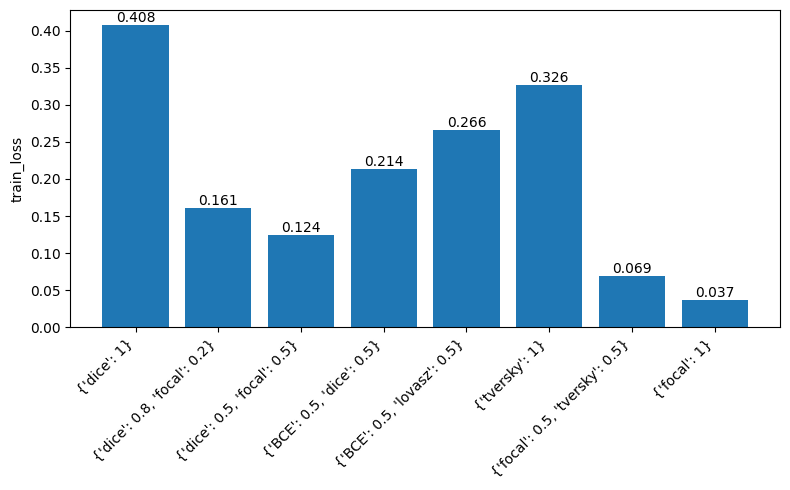

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


C:\Users\fhcar\AppData\Local\Temp\ipykernel_28404\2846584638.py:60: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(metrics[x_metric], metrics[y_metric], label=get_metadata_field(metadata, subject))
C:\Users\fhcar\AppData\Local\Temp\ipykernel_28404\2846584638.py:60: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(metrics[x_metric], metrics[y_metric], label=get_metadata_field(metadata, subject))
C:\Users\fhcar\AppData\Local\Temp\ipykernel_28404\2846584638.py:60: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.

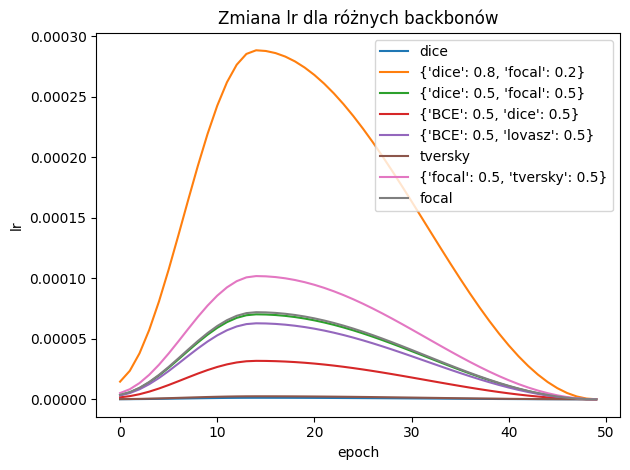

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


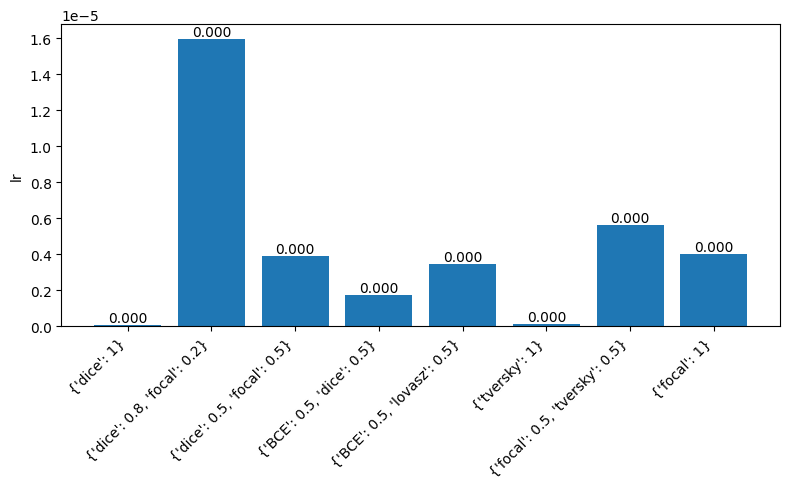

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


C:\Users\fhcar\AppData\Local\Temp\ipykernel_28404\2846584638.py:60: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(metrics[x_metric], metrics[y_metric], label=get_metadata_field(metadata, subject))
C:\Users\fhcar\AppData\Local\Temp\ipykernel_28404\2846584638.py:60: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(metrics[x_metric], metrics[y_metric], label=get_metadata_field(metadata, subject))
C:\Users\fhcar\AppData\Local\Temp\ipykernel_28404\2846584638.py:60: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.

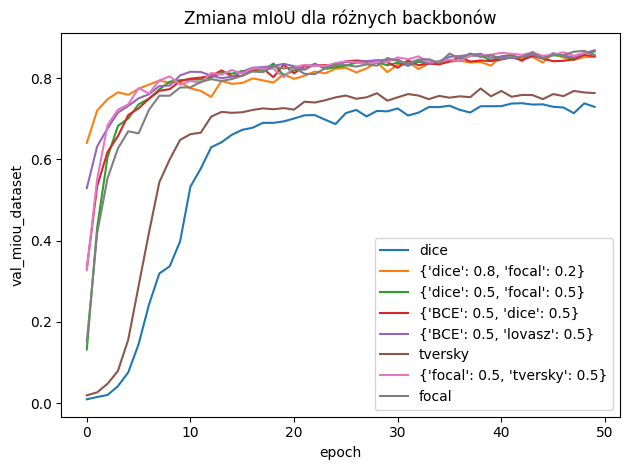

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


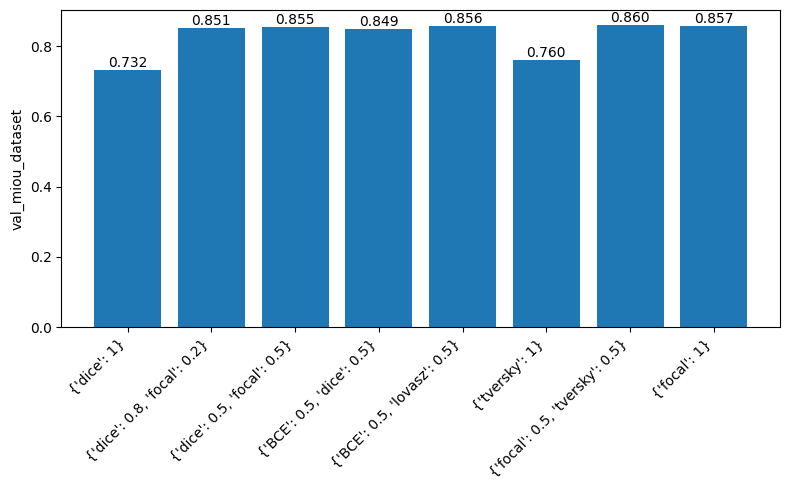

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


C:\Users\fhcar\AppData\Local\Temp\ipykernel_28404\2846584638.py:60: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(metrics[x_metric], metrics[y_metric], label=get_metadata_field(metadata, subject))
C:\Users\fhcar\AppData\Local\Temp\ipykernel_28404\2846584638.py:60: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(metrics[x_metric], metrics[y_metric], label=get_metadata_field(metadata, subject))
C:\Users\fhcar\AppData\Local\Temp\ipykernel_28404\2846584638.py:60: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.

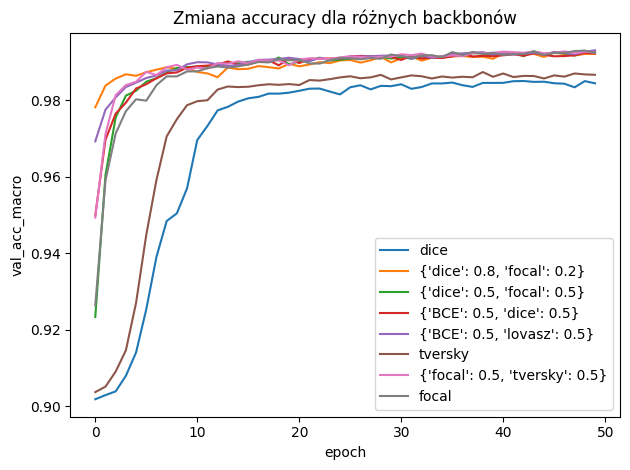

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


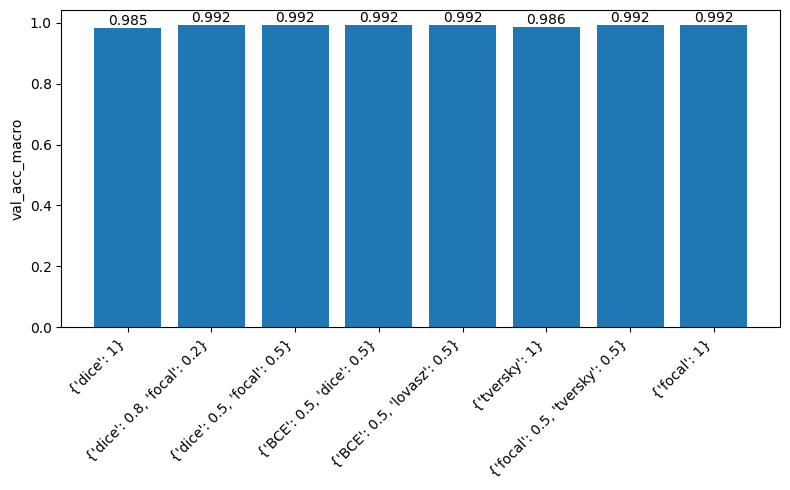

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


C:\Users\fhcar\AppData\Local\Temp\ipykernel_28404\2846584638.py:60: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(metrics[x_metric], metrics[y_metric], label=get_metadata_field(metadata, subject))
C:\Users\fhcar\AppData\Local\Temp\ipykernel_28404\2846584638.py:60: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(metrics[x_metric], metrics[y_metric], label=get_metadata_field(metadata, subject))
C:\Users\fhcar\AppData\Local\Temp\ipykernel_28404\2846584638.py:60: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.

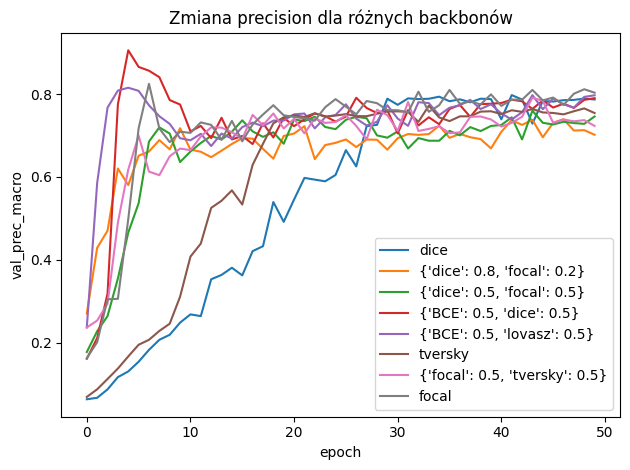

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


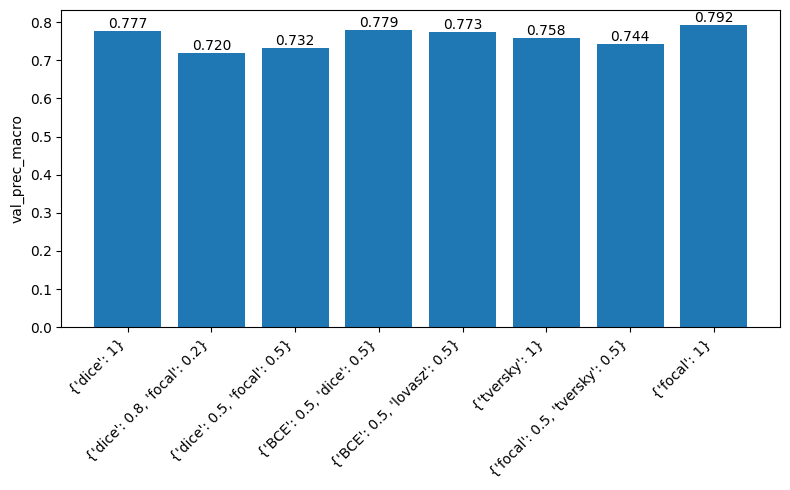

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


C:\Users\fhcar\AppData\Local\Temp\ipykernel_28404\2846584638.py:60: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(metrics[x_metric], metrics[y_metric], label=get_metadata_field(metadata, subject))
C:\Users\fhcar\AppData\Local\Temp\ipykernel_28404\2846584638.py:60: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(metrics[x_metric], metrics[y_metric], label=get_metadata_field(metadata, subject))
C:\Users\fhcar\AppData\Local\Temp\ipykernel_28404\2846584638.py:60: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.

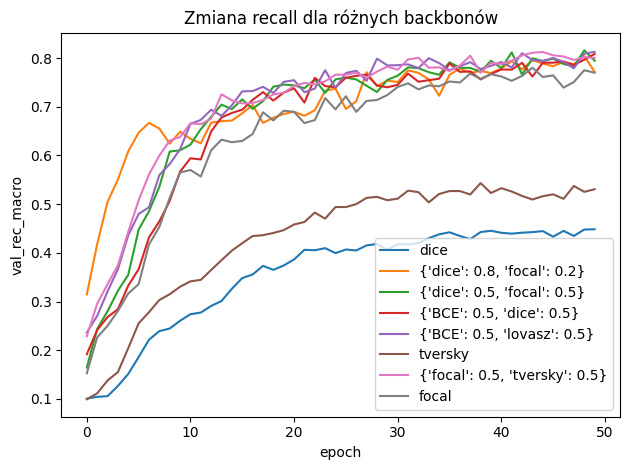

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


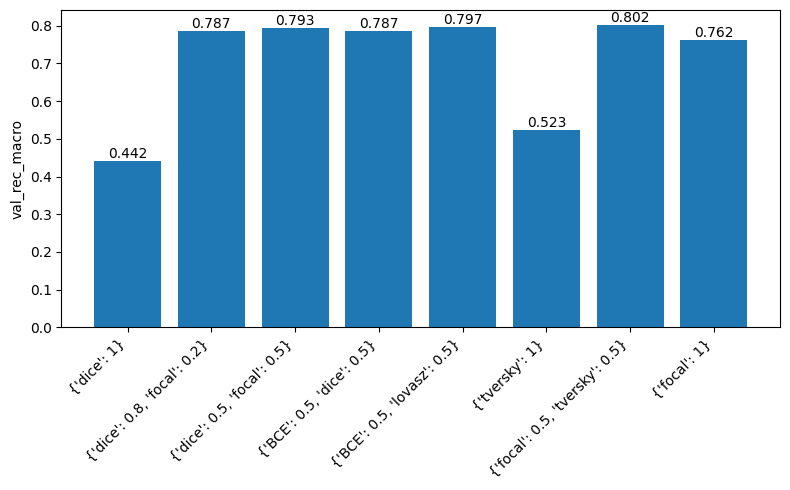

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


C:\Users\fhcar\AppData\Local\Temp\ipykernel_28404\2846584638.py:60: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(metrics[x_metric], metrics[y_metric], label=get_metadata_field(metadata, subject))
C:\Users\fhcar\AppData\Local\Temp\ipykernel_28404\2846584638.py:60: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(metrics[x_metric], metrics[y_metric], label=get_metadata_field(metadata, subject))
C:\Users\fhcar\AppData\Local\Temp\ipykernel_28404\2846584638.py:60: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.

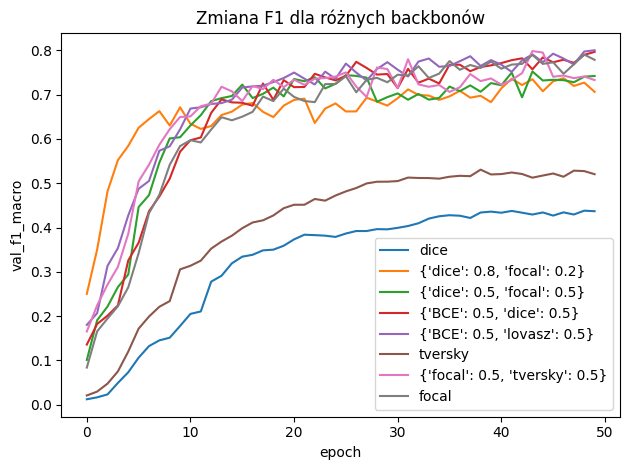

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


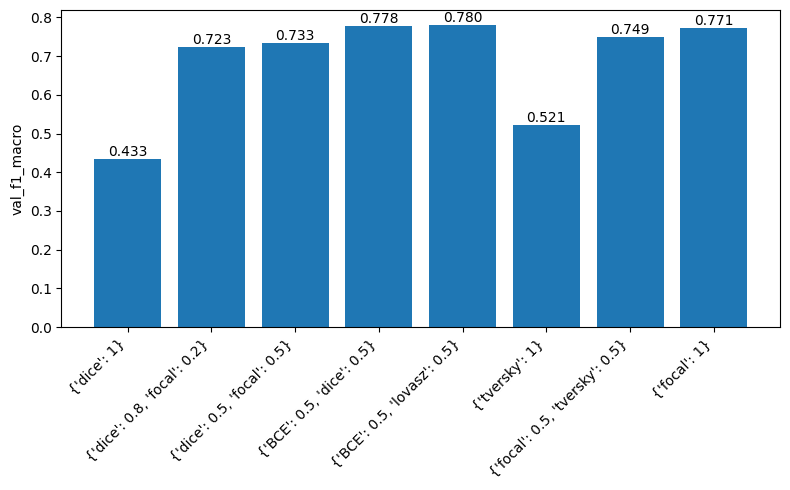

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


C:\Users\fhcar\AppData\Local\Temp\ipykernel_28404\2846584638.py:60: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(metrics[x_metric], metrics[y_metric], label=get_metadata_field(metadata, subject))
C:\Users\fhcar\AppData\Local\Temp\ipykernel_28404\2846584638.py:60: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(metrics[x_metric], metrics[y_metric], label=get_metadata_field(metadata, subject))
C:\Users\fhcar\AppData\Local\Temp\ipykernel_28404\2846584638.py:60: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.

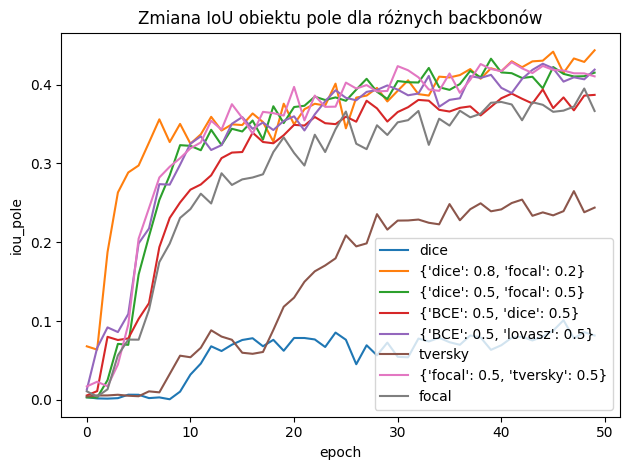

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


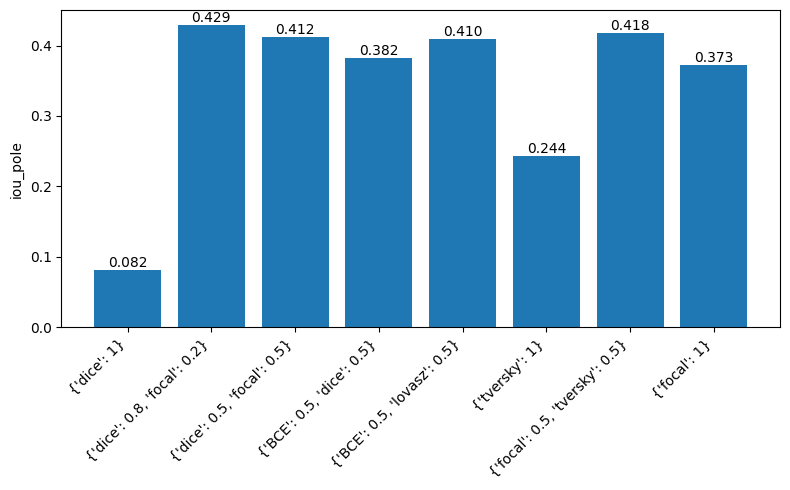

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


C:\Users\fhcar\AppData\Local\Temp\ipykernel_28404\2846584638.py:60: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(metrics[x_metric], metrics[y_metric], label=get_metadata_field(metadata, subject))
C:\Users\fhcar\AppData\Local\Temp\ipykernel_28404\2846584638.py:60: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(metrics[x_metric], metrics[y_metric], label=get_metadata_field(metadata, subject))
C:\Users\fhcar\AppData\Local\Temp\ipykernel_28404\2846584638.py:60: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.

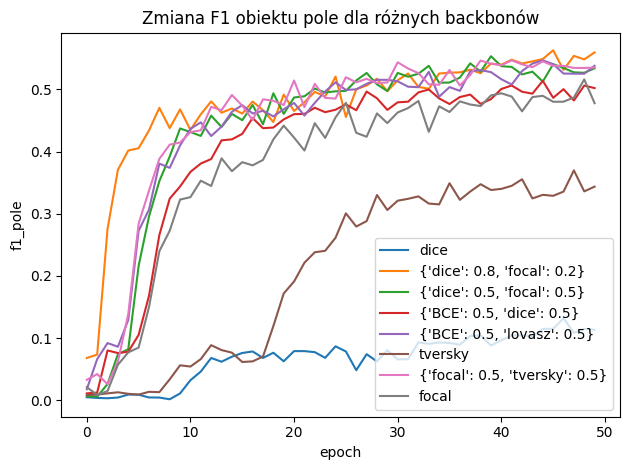

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


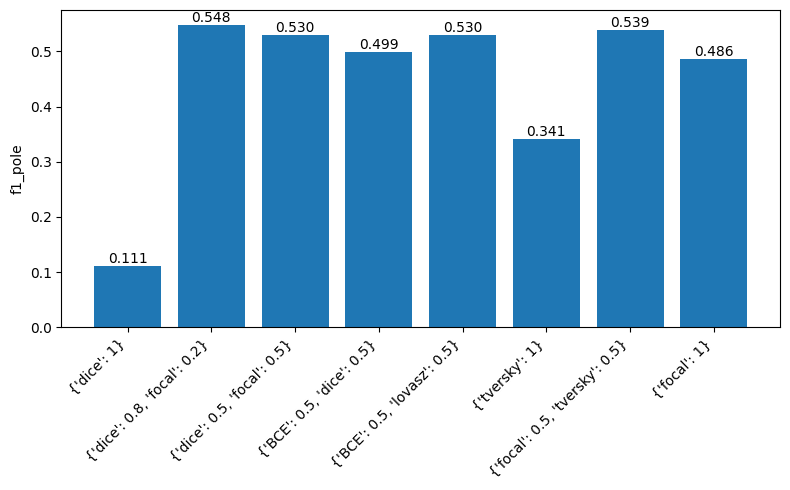

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


C:\Users\fhcar\AppData\Local\Temp\ipykernel_28404\2846584638.py:60: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(metrics[x_metric], metrics[y_metric], label=get_metadata_field(metadata, subject))
C:\Users\fhcar\AppData\Local\Temp\ipykernel_28404\2846584638.py:60: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(metrics[x_metric], metrics[y_metric], label=get_metadata_field(metadata, subject))
C:\Users\fhcar\AppData\Local\Temp\ipykernel_28404\2846584638.py:60: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.

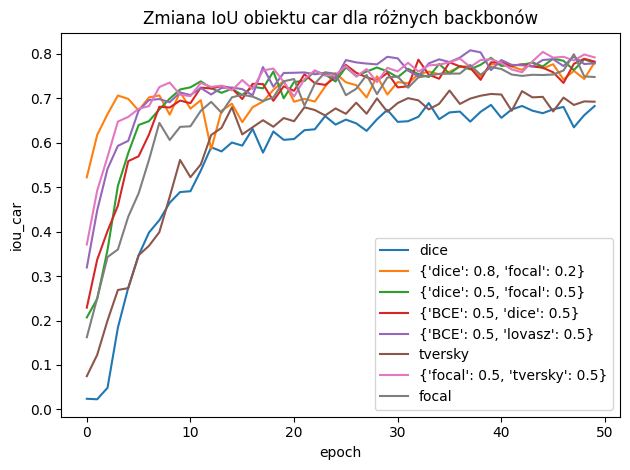

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


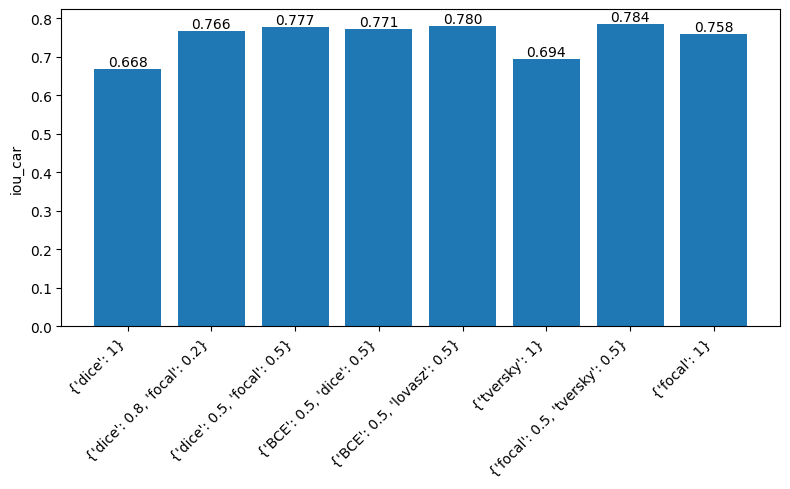

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


C:\Users\fhcar\AppData\Local\Temp\ipykernel_28404\2846584638.py:60: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(metrics[x_metric], metrics[y_metric], label=get_metadata_field(metadata, subject))
C:\Users\fhcar\AppData\Local\Temp\ipykernel_28404\2846584638.py:60: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(metrics[x_metric], metrics[y_metric], label=get_metadata_field(metadata, subject))
C:\Users\fhcar\AppData\Local\Temp\ipykernel_28404\2846584638.py:60: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.

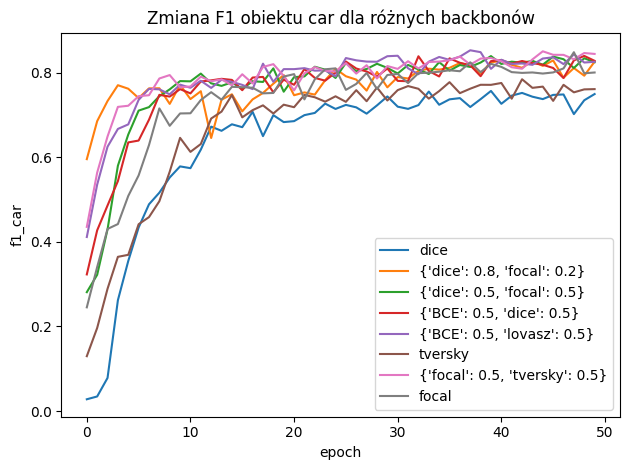

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


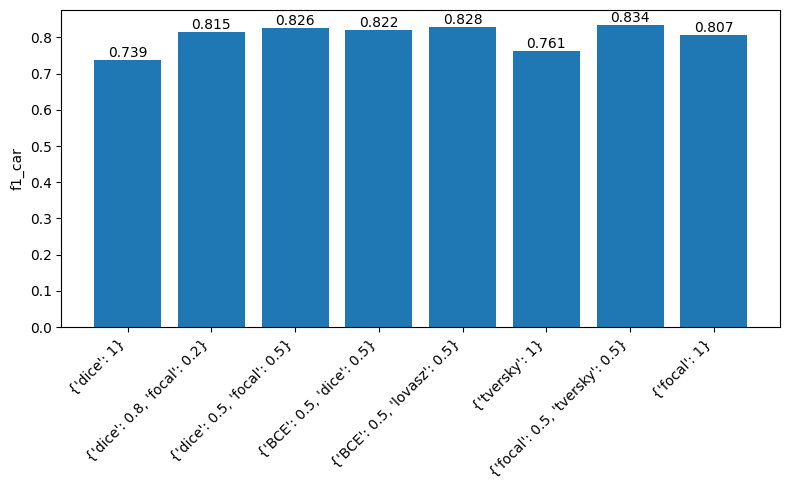

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


C:\Users\fhcar\AppData\Local\Temp\ipykernel_28404\2846584638.py:60: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(metrics[x_metric], metrics[y_metric], label=get_metadata_field(metadata, subject))
C:\Users\fhcar\AppData\Local\Temp\ipykernel_28404\2846584638.py:60: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(metrics[x_metric], metrics[y_metric], label=get_metadata_field(metadata, subject))
C:\Users\fhcar\AppData\Local\Temp\ipykernel_28404\2846584638.py:60: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.

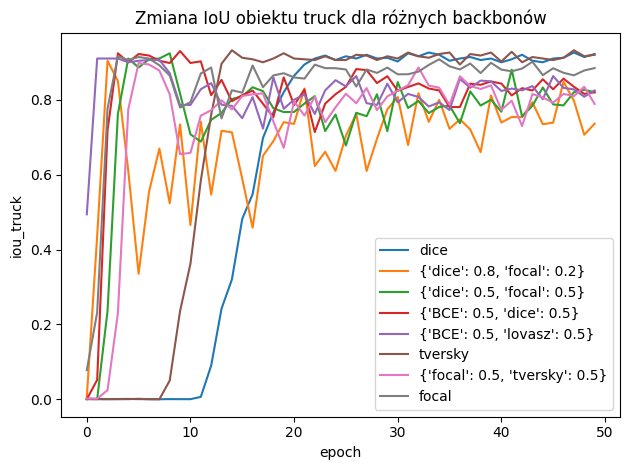

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


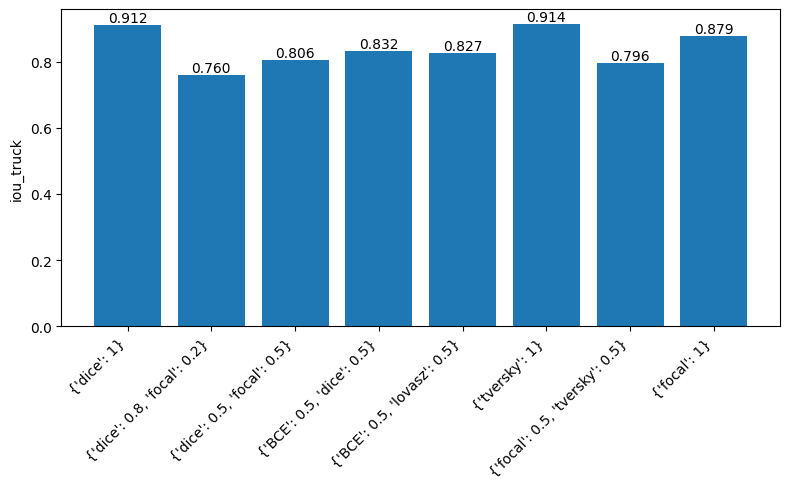

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


C:\Users\fhcar\AppData\Local\Temp\ipykernel_28404\2846584638.py:60: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(metrics[x_metric], metrics[y_metric], label=get_metadata_field(metadata, subject))
C:\Users\fhcar\AppData\Local\Temp\ipykernel_28404\2846584638.py:60: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(metrics[x_metric], metrics[y_metric], label=get_metadata_field(metadata, subject))
C:\Users\fhcar\AppData\Local\Temp\ipykernel_28404\2846584638.py:60: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.

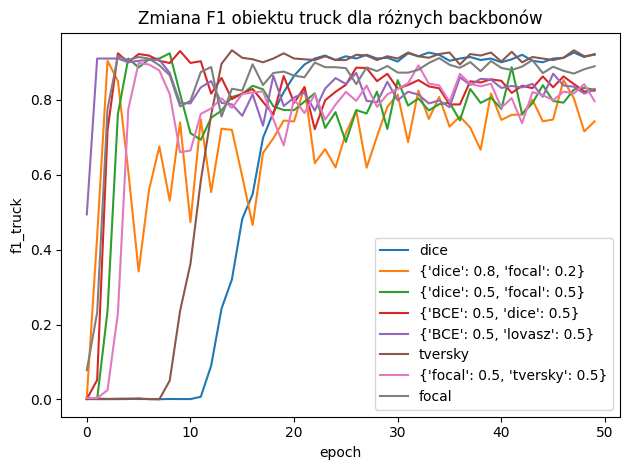

['Unet', 'DeepLabV3Plus', 'Segformer', 'PAN']


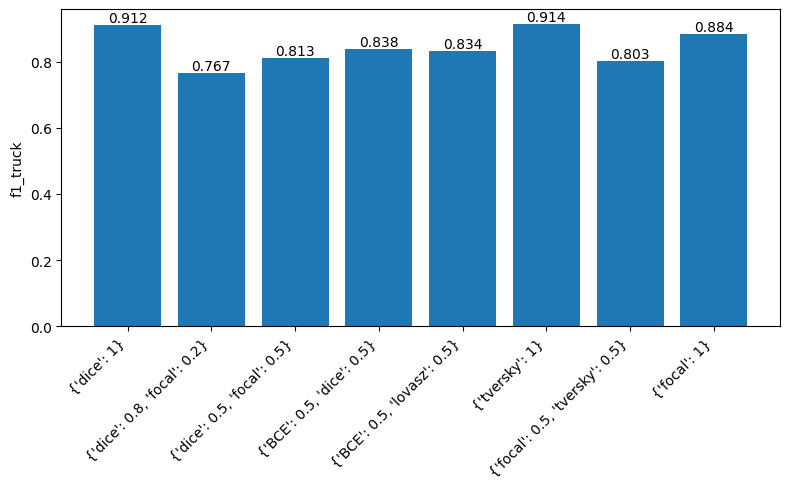

In [7]:
logs_root = ".\\logs\\"

for metrics in comparision_metrics:
    draw_backbone_comparision_plot(
        title=metrics[0],
        y_metric=metrics[1],
        metrics_files=get_metrics_files(logs_root, backbones_final),
        subject='loss_fn'
    )

    visualize_accumulated(
        metrics_files=get_metrics_files(logs_root, backbones_final),
        y_metric=metrics[1],
        subject='loss_fn'
    )

### Eksperyment na wybranych konfiguracjach funkcji straty

In [8]:
import os
import yaml
import glob

# logs_root = ".\\logs\\"
# for model_dir in glob.glob(os.path.join(logs_root, '*')):
#     for version_dir in glob.glob(os.path.join(model_dir, '*')):
#         metadata_file = os.path.join(version_dir, 'metadata.csv')
#         if not os.path.exists(metadata_file):
#             continue
#         metadata = pd.read_csv(metadata_file).loc[0]
#         metadata_new = f"""
#             'model':
#             - 'name': {metadata.model}
#             - 'encoder': {metadata.enoder}
#             - 'weights': {metadata.weights}
#             - 'loss_fn':
#                 - 'Dice Loss': 0.8
#                 - 'Focal Loss': 0.2
#             - 'peak_lr': {metadata.peak_lr}
#             - 'time':
#                 - 'start': {metadata.start_time}
#                 - 'finish': {metadata.finish_time}
#         """
#         metadata_new = yaml.safe_load(metadata_new)
#         with open(os.path.join(version_dir, 'metadata.yaml'), 'w') as file:
#             yaml.dump(metadata_new, file)

# test = yaml.safe_load(test)

